In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="0"


from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model, Sequential

from keras.regularizers import l2, l1, l1_l2


import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping


import pickle


2025-03-24 08:25:44.054619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 08:25:44.093836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8463] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 08:25:44.105538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import optree
import keras
print( '\n\n')
print(' optree version:  %s' % str(optree.__version__))
print(' keras version:  %s' % str(keras.__version__))
print('\n\n')




 optree version:  0.13.0
 keras version:  3.4.1





In [3]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.17.0





In [4]:
from keras.layers import Activation

beta = 4

def custom_activation(x):
    return 0.5 * x * (1 + K.tanh( beta * 0.79788 * (x + 0.044715 * x * x * x)))

## Set model and resolution parameters

In [5]:
##====================

ndim = 6

n_boot_samples = 500


resolution_sf = 1.00

output_dir = 'output-run-nn-study-nd-v0j-ndim%d-res-sf-%.2f' % (ndim, resolution_sf)


##-------------

if ndim == 6 :

    mc_mu = [ 1.,  0.,  -0.5,   0.5, -1., 0.3 ]

    mc_rho = [ 
                  [0.0, 0.0, -0.3, 0.2, 0.1],  #0
                  [0.1, 0.3, -0.2, 0.0 ],   #1
                  [0.3, -0.2, 0.1   ],  #2
                  [0.0, 0.1],  #3
                  [0.7],  #4
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8, 1.2, 1.4 ]


    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7, -0.8, 0.1 ]

    true_rho  = [ [0.0, 0.1, -0.2, 0.2, 0.0 ], #0
                  [0.0, 0.2, -0.1, 0.0],  #1
                  [0.4, -0.3, 0.0   ],  #2
                  [0.0, 0.2],  #3
                  [0.5],  #4
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6, 1.0, 1.1 ]
    
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3, 0.4, 0.4  ]
    
    

##-------------

if ndim == 4 :
    
    mc_mu = [ 1.,  0.,  -0.5,   0.5 ]

    mc_rho = [ 
                  [0.3, -0.2, 0.1   ],  #0
                  [0.0, 0.1],  #1
                  [0.7],  #2
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8 ]
    
    
    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7 ]

    true_rho  = [ 
                  [0.4, -0.3, 0.0   ],  #0
                  [0.0, 0.2],  #1
                  [0.5],  #2
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6 ]
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3  ]
    
    

##-------------

if ndim == 2 :
    
    mc_mu = [ 0.0, 1.0 ]

    mc_rho = [ [-0.6] ]

    mc_sig = [ 1.0, 1.5 ]


    ##-------------

    true_mu = [ 0.2, 0.8 ]

    true_rho  = [ [-0.6] ]

    true_sig = [ 0.9, 1.3 ]
    
    
    resolution = [ 0.5, 0.8  ]

    
##-------------

if ndim == 1 :

    ##-------------

    mc_mu = [ 0.0 ]

    mc_rho = [ [0.0] ]

    mc_sig = [ 1.0 ]


    ##-------------


    true_mu = [ 0.2 ]

    true_rho  = [ [0.0] ]

    true_sig = [ 0.9 ]  

    
    resolution = [ 0.5  ]









##=====================


#-- scale resolution 

for i in range( len(resolution) ) :
    resolution[i] = resolution_sf * resolution[i]
print('\n\n Resolution: %s\n\n' % str(resolution))


mc_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n mc covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            mc_cov[i][j] = mc_sig[i] * mc_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, mc_cov[i][j]))
        else :
            k = ndim - j - 1
            mc_cov[i][j] = mc_sig[i] * mc_sig[j] * mc_rho[i][k]
            mc_cov[j][i] = mc_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, mc_sig[i], mc_sig[j], mc_rho[i][k], mc_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_mc = 100000
ngen_true =  10000



of_niter = 5

learning_rate_setval = 0.0005





epochs_setval = 400

#patience_setval = 25
patience_setval = 100

restore_best_weights_setval = False



use_batch_norm = False

units_per_layer = 50


number_of_layers = 3




dropout_setval = 0.0


batch_size_setval = int( ngen_true )






#activation_setval = 'relu'

activation_setval = custom_activation





do_bootstrap = False




use_poisson_fluctuations_around_ngen_true = True


random_seed = 1




save_step2_model = True




 Resolution: [0.4, 0.5, 0.6, 0.3, 0.4, 0.4]





 mc covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    0.700 *    0.100 =   0.0700
   0,  2 :              1.000 *    1.100 *    0.200 =   0.2200
   0,  3 :              1.000 *    0.800 *   -0.300 =  -0.2400
   0,  4 :              1.000 *    1.200 *    0.000 =   0.0000
   0,  5 :              1.000 *    1.400 *    0.000 =   0.0000
   1,  1 : diagonal    0.4900
   1,  2 :              0.700 *    1.100 *    0.000 =   0.0000
   1,  3 :              0.700 *    0.800 *   -0.200 =  -0.1120
   1,  4 :              0.700 *    1.200 *    0.300 =   0.2520
   1,  5 :              0.700 *    1.400 *    0.100 =   0.0980
   2,  2 : diagonal    1.2100
   2,  3 :              1.100 *    0.800 *    0.100 =   0.0880
   2,  4 :              1.100 *    1.200 *   -0.200 =  -0.2640
   2,  5 :              1.100 *    1.400 *    0.300 =   0.4620
   3,  3 : diagonal    0.6400
   3,  4 :              0.800 *    1.200 *    0.100 =   0

In [6]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  output-run-nn-study-nd-v0j-ndim6-res-sf-1.00


In [7]:
print("\n\n")
print("mc covariance determinant:  %f" % np.linalg.det( mc_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




mc covariance determinant:  0.172508
True covariance determinant:   0.021873





In [8]:
mc_cov_inv = np.linalg.inv( mc_cov )

In [9]:
mc_cov_inv_test = np.matmul( mc_cov, mc_cov_inv )

In [10]:
print("\n\n")
print(" mc covariance")
print( mc_cov )
print("\n mc covariance inverse")
print( mc_cov_inv )
print("\n mc covariance inverse test")
print(mc_cov_inv_test)
print("\n\n")




 mc covariance
[[ 1.     0.07   0.22  -0.24   0.     0.   ]
 [ 0.07   0.49   0.    -0.112  0.252  0.098]
 [ 0.22   0.     1.21   0.088 -0.264  0.462]
 [-0.24  -0.112  0.088  0.64   0.096  0.   ]
 [ 0.     0.252 -0.264  0.096  1.44   1.176]
 [ 0.     0.098  0.462  0.     1.176  1.96 ]]

 mc covariance inverse
[[ 1.27716902  0.1656726  -0.58002342  0.67150396 -0.55879766  0.46371477]
 [ 0.1656726   2.73570114 -0.70653543  0.84055786 -1.35022875  0.83989269]
 [-0.58002342 -0.70653543  1.92056726 -0.8623171   1.7139108  -1.44572485]
 [ 0.67150396  0.84055786 -0.8623171   2.25263852 -1.15105541  0.85186581]
 [-0.55879766 -1.35022875  1.7139108  -1.15105541  3.1303568  -2.2146959 ]
 [ 0.46371477  0.83989269 -1.44572485  0.85186581 -2.2146959   2.13780499]]

 mc covariance inverse test
[[ 1.00000000e+00  3.85518982e-17  2.34273303e-17  6.68477293e-18
   2.53037110e-17  1.97785416e-17]
 [ 1.03272453e-18  1.00000000e+00 -7.55439088e-17  5.16034005e-18
  -6.75529269e-17 -1.93778609e-17]
 [-5.

In [11]:
true_cov_inv = np.linalg.inv( true_cov )

In [12]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [13]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.64   0.     0.16  -0.096  0.08   0.   ]
 [ 0.     0.36   0.    -0.036  0.12   0.   ]
 [ 0.16   0.     1.     0.    -0.3    0.44 ]
 [-0.096 -0.036  0.     0.36   0.12   0.   ]
 [ 0.08   0.12  -0.3    0.12   1.     0.55 ]
 [ 0.     0.     0.44   0.     0.55   1.21 ]]

 True covariance inverse
[[ 2.16720735  0.5238541  -1.16089127  1.0492377  -1.25679098  0.99341091]
 [ 0.5238541   3.3098402  -0.88711059  0.91158261 -1.32271248  0.92381861]
 [-1.16089127 -0.88711059  2.78705675 -1.16853878  2.31077013 -2.06382524]
 [ 1.0492377   0.91158261 -1.16853878  3.69119578 -1.62738908  1.1646455 ]
 [-1.25679098 -1.32271248  2.31077013 -1.62738908  3.47992071 -2.42206219]
 [ 0.99341091  0.92381861 -2.06382524  1.1646455  -2.42206219  2.67786555]]

 True covariance inverse test
[[ 1.00000000e+00  1.33027204e-17 -1.95945683e-17  4.79800120e-17
  -1.36869527e-16 -2.54339557e-17]
 [-1.08006500e-18  1.00000000e+00  4.52492704e-17  3.38724119e-17
  -2.43357366e-17  1.51970089e-17]

## Generate samples, save events and config

In [14]:

np.random.seed( random_seed )
keras.utils.set_random_seed( random_seed )


mc_pts = np.random.multivariate_normal(mc_mu, mc_cov, size=ngen_mc)


this_ngen_true = ngen_true
if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )

true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)


mc_det_pts = np.random.normal( mc_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



In [15]:
with open( '%s/mc-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, mc_pts)
    np.save(f, mc_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [16]:
with open('%s/config-pars.pkl' % output_dir, 'wb') as f :
    pickle.dump( mc_mu, f)
    pickle.dump( mc_rho, f)
    pickle.dump( mc_sig, f)
    pickle.dump( true_mu,f)
    pickle.dump( true_rho,f)
    pickle.dump( true_sig,f)
    pickle.dump( resolution,f)
    pickle.dump( mc_cov,f)
    pickle.dump( true_cov,f)


In [17]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_mc %d\n' % ngen_mc )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )
config_file.write('use_poisson_fluctuations_around_total : %s\n' % str(use_poisson_fluctuations_around_ngen_true) )
config_file.write( 'random_seed:  %d\n' % random_seed  )
config_file.write('activation_setval  %s\n' % activation_setval )
config_file.write('beta  %s\n' % beta )
config_file.write('patience_setval  %d\n' % patience_setval )
config_file.write('restore_best_weights_setval  %s\n' % str(restore_best_weights_setval) )


config_file.write('\n\n')
config_file.write('mc_mu : %s\n' % str(mc_mu))
config_file.write('mc_rho : %s\n' % str(mc_rho))
config_file.write('mc_sig : %s\n' % str(mc_sig))
config_file.write('mc_cov : %s\n' % str(mc_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution_sf :  %.2f\n' % resolution_sf )
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/config.txt

2025-03-24 08:25:46.646810

ngen_mc 100000
ngen_true  10000
of_niter   5
ndim       6
learning_rate_setval  0.000500
epochs_setval  400
batch_size_setval  10000
use_poisson_fluctuations_around_total : True
random_seed:  1
activation_setval  <function custom_activation at 0x741a0a59f010>
beta  4
patience_setval  100
restore_best_weights_setval  False


mc_mu : [1.0, 0.0, -0.5, 0.5, -1.0, 0.3]
mc_rho : [[0.0, 0.0, -0.3, 0.2, 0.1], [0.1, 0.3, -0.2, 0.0], [0.3, -0.2, 0.1], [0.0, 0.1], [0.7]]
mc_sig : [1.0, 0.7, 1.1, 0.8, 1.2, 1.4]
mc_cov : [[ 1.     0.07   0.22  -0.24   0.     0.   ]
 [ 0.07   0.49   0.    -0.112  0.252  0.098]
 [ 0.22   0.     1.21   0.088 -0.264  0.462]
 [-0.24  -0.112  0.088  0.64   0.096  0.   ]
 [ 0.     0.252 -0.264  0.096  1.44   1.176]
 [ 0.     0.098  0.462  0.     1.176  1.96 ]]


true_mu : [0.8, 0.1, -0.6, 0.7, -0.8, 0.1]
true_rho : [[0.0, 0.1, -0.2, 0.2, 0.0], [0.0, 0.2, -0.1, 0

## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

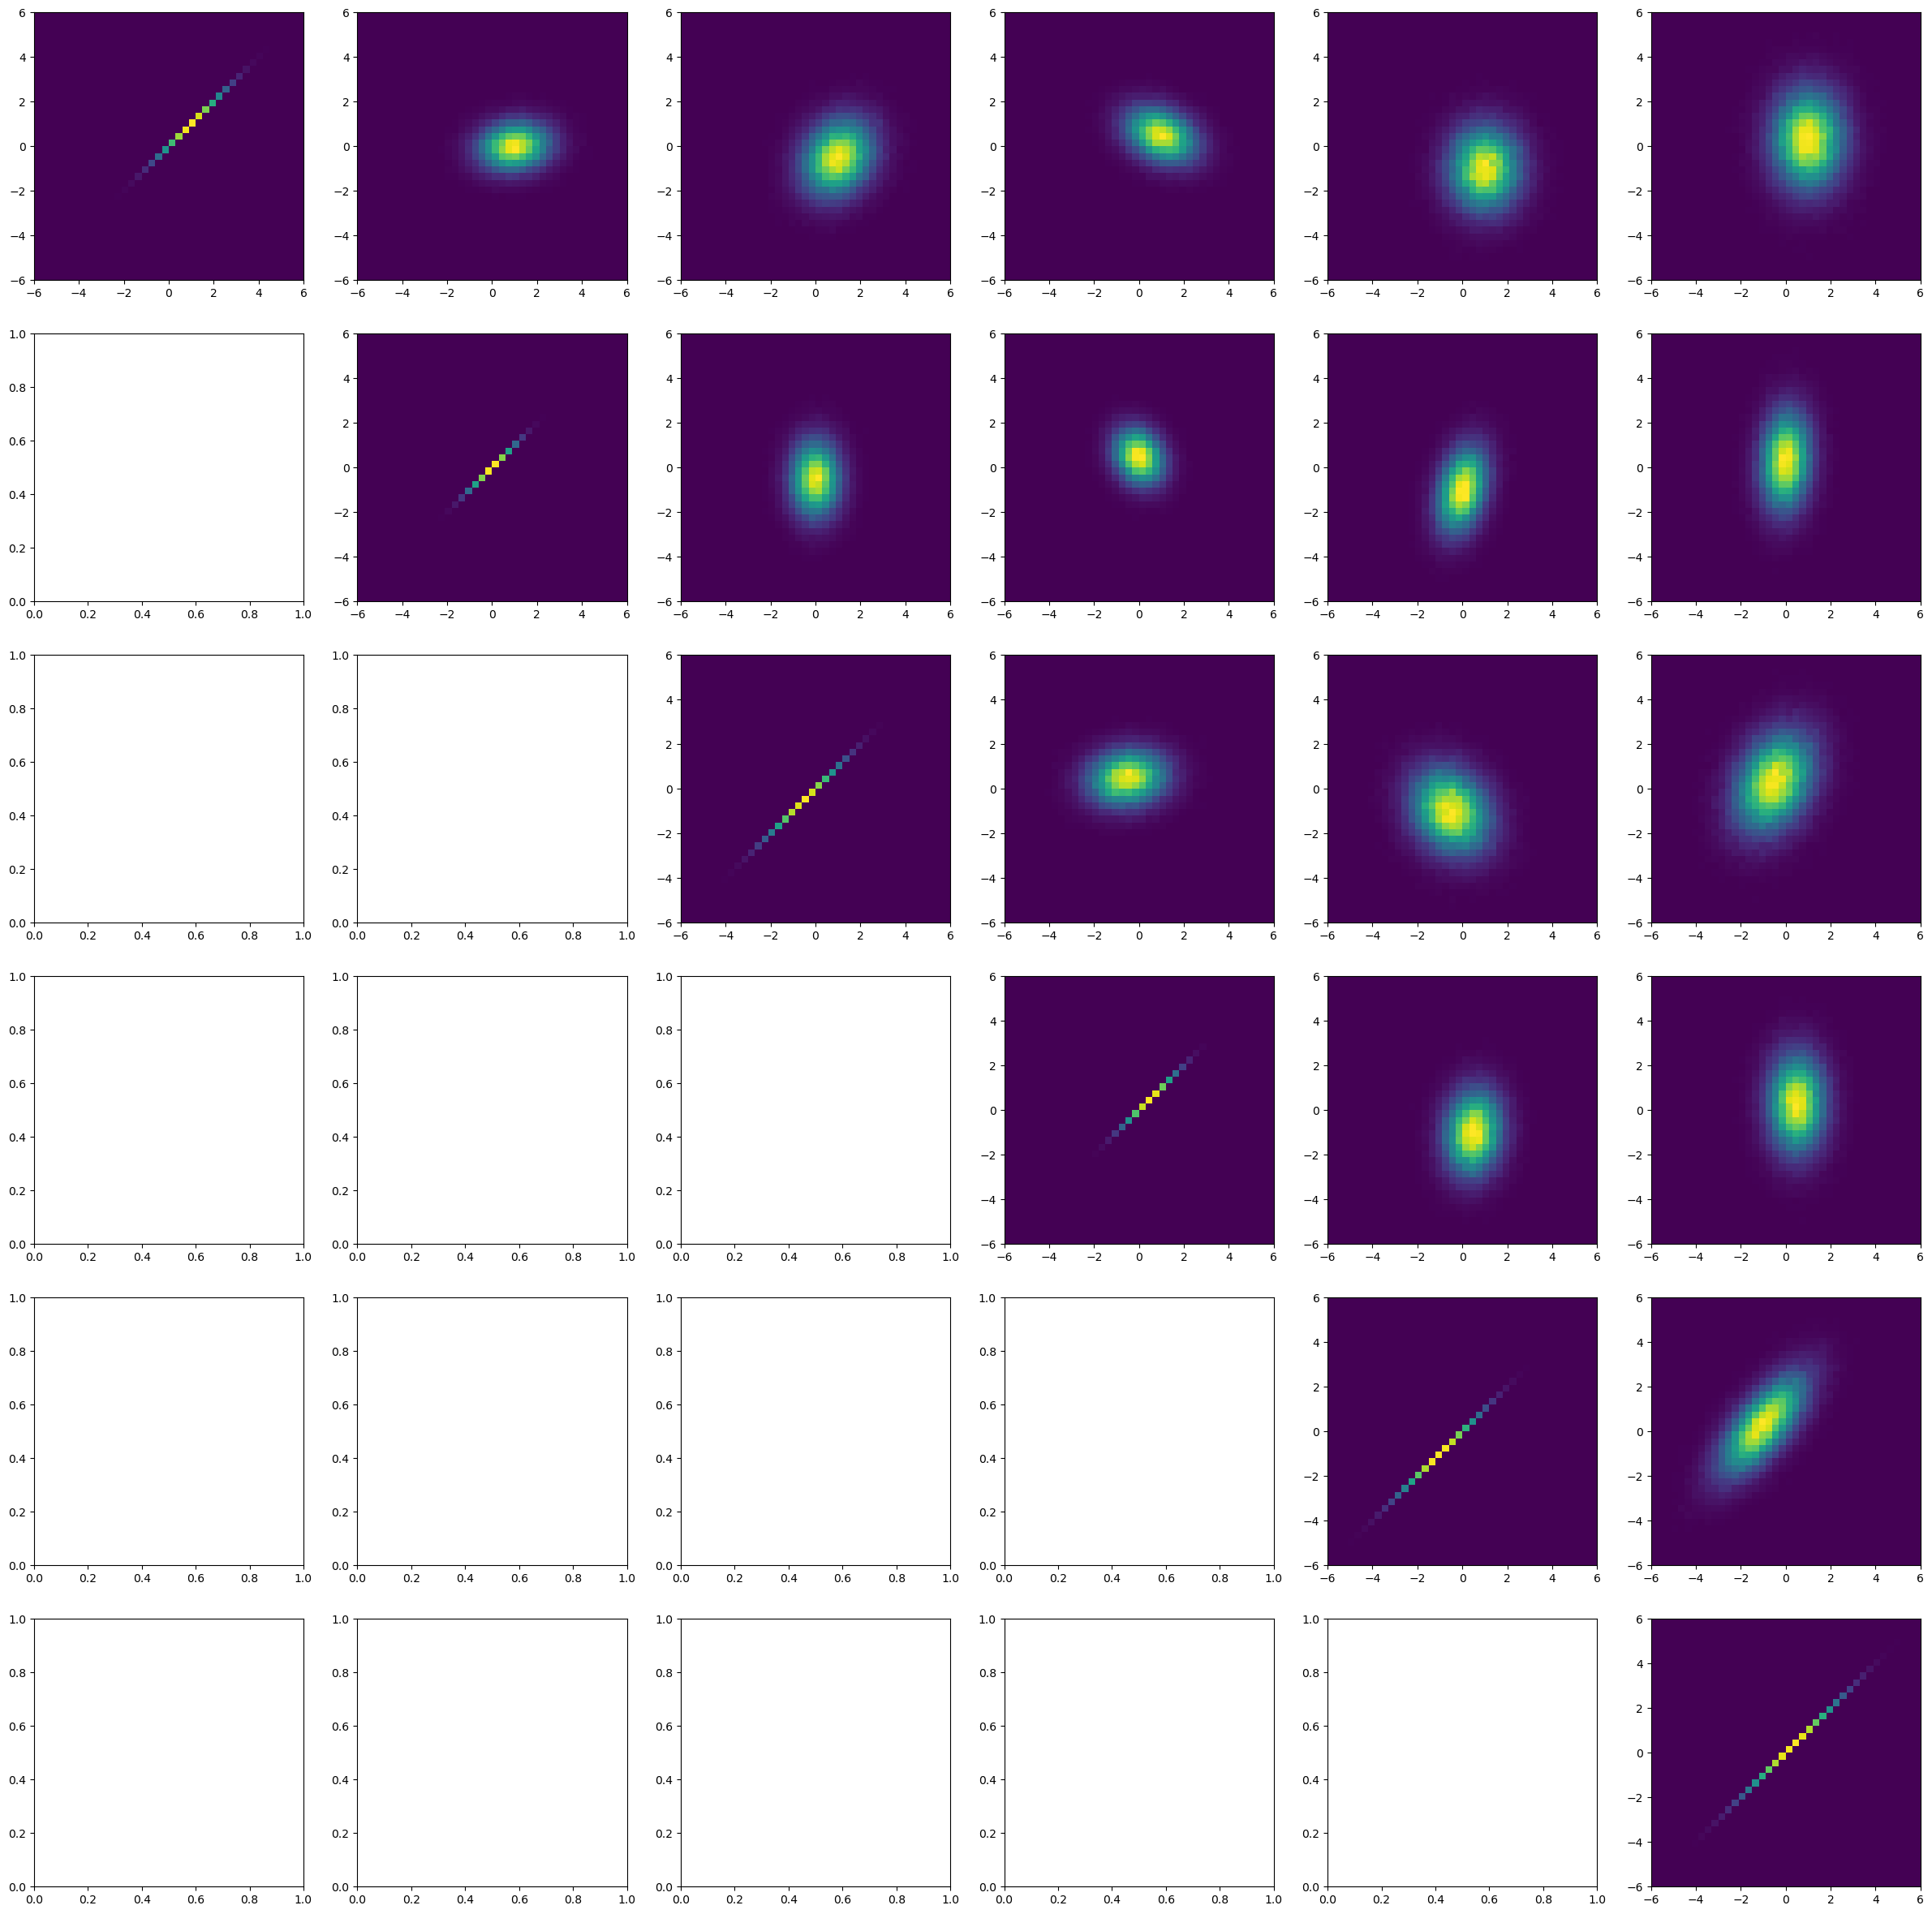

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( mc_pts[:,i], mc_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

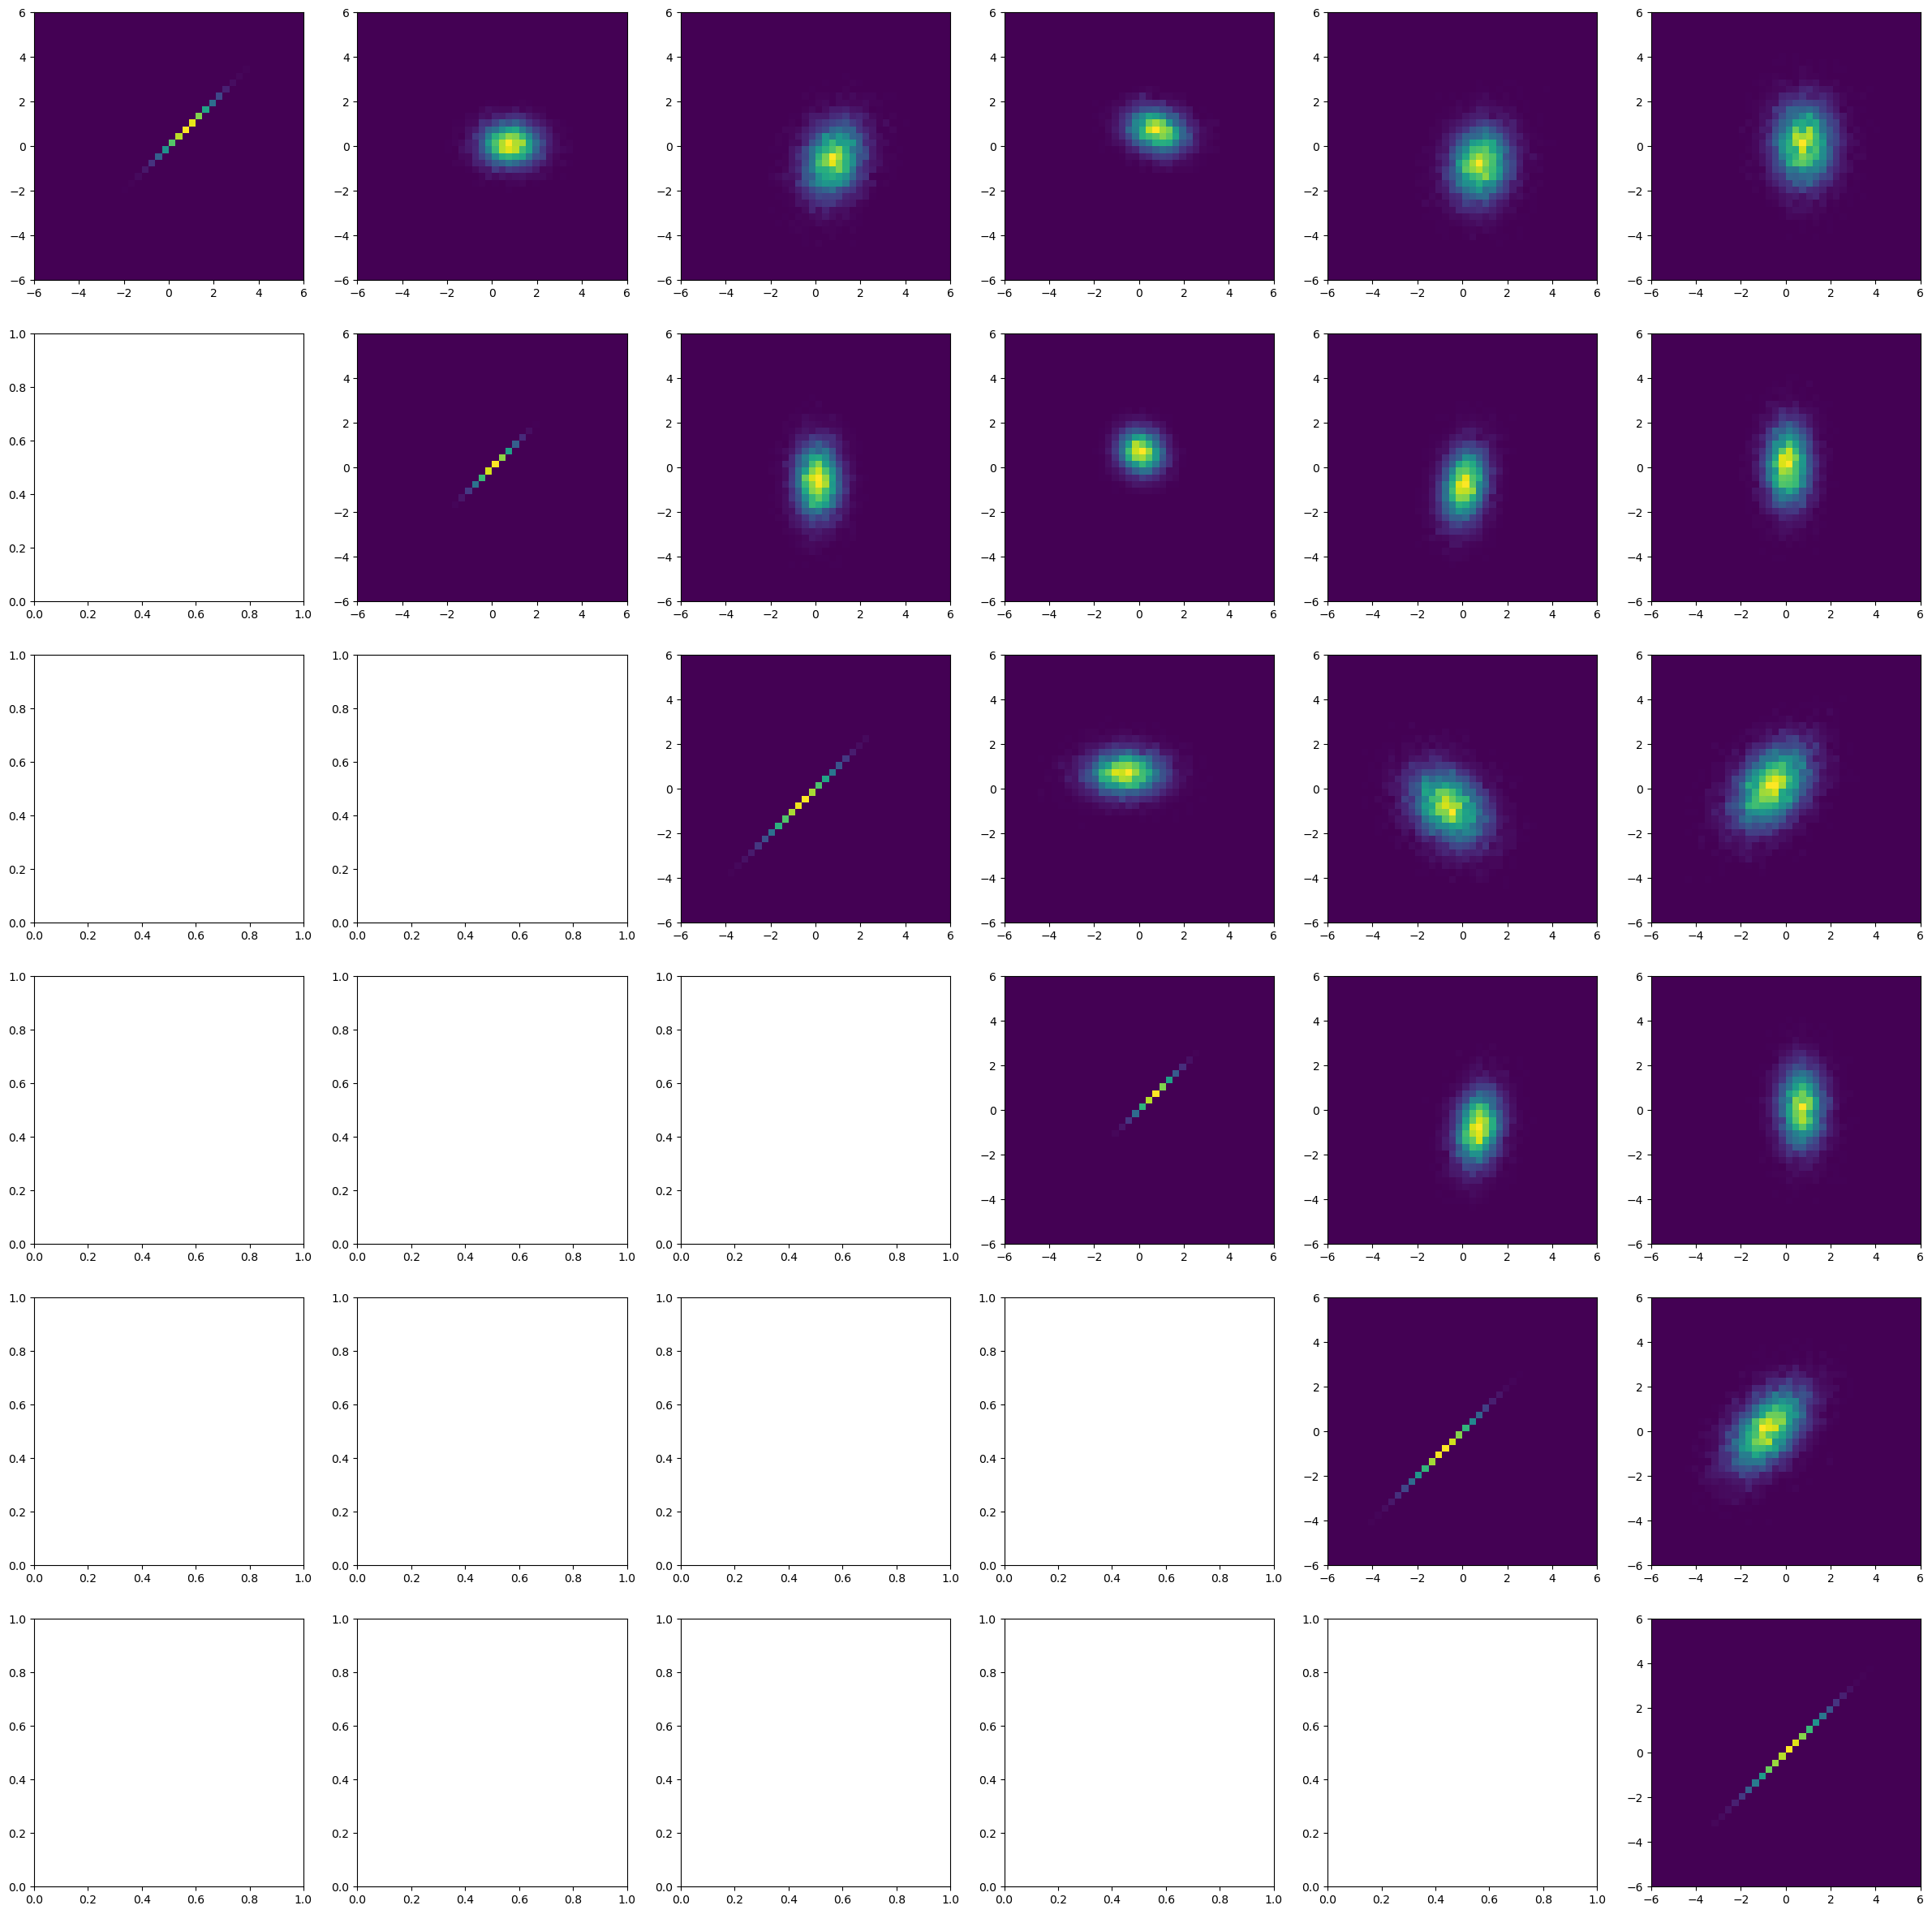

In [19]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

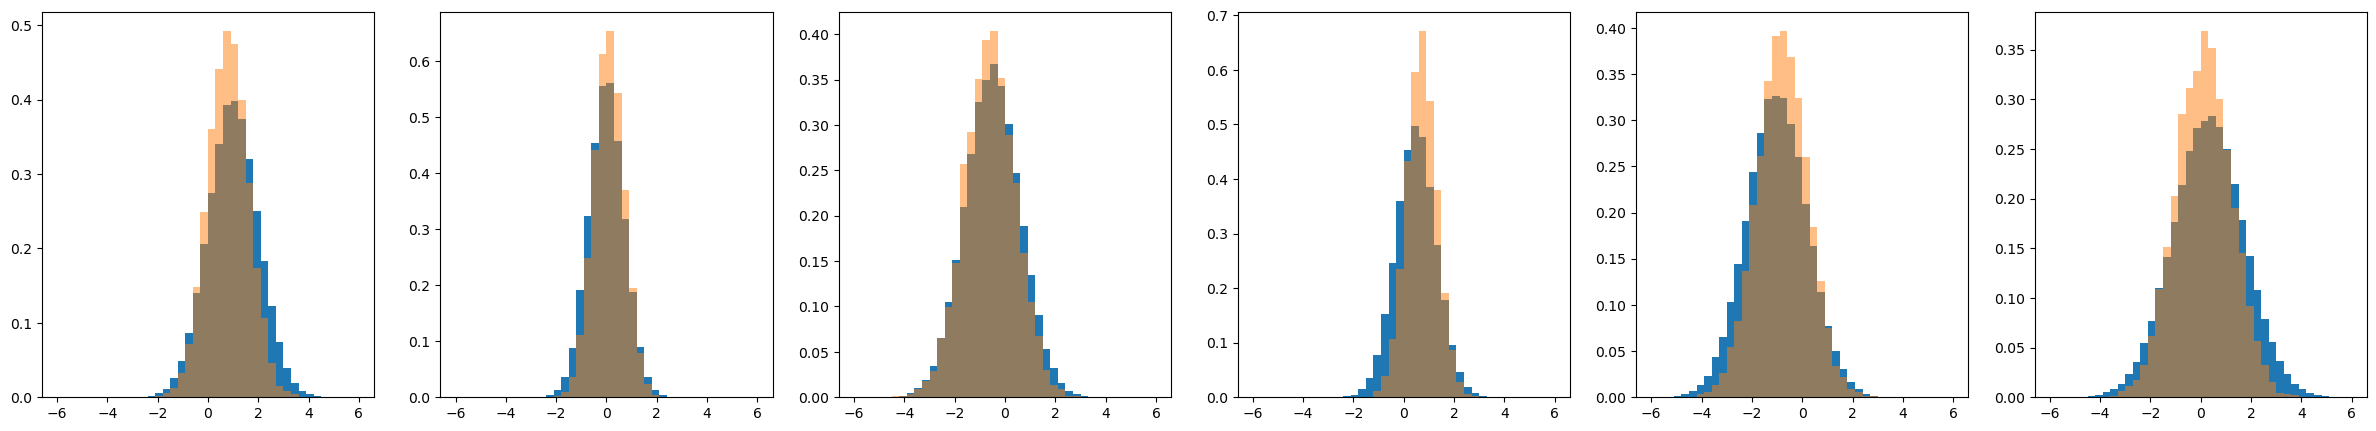

In [20]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i]
        axi.hist( mc_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        axi.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [21]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [22]:









#-- off
l2reg_setval = 0.0





#-- off
al2reg_setval = 0.0




model_step1 = Sequential()

model_step1.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step1.add( BatchNormalization() )
model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

model_step1.add( Dense(1, activation='sigmoid') )





model_step2 = Sequential()

model_step2.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step2.add( BatchNormalization() )
model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

model_step2.add( Dense(1, activation='sigmoid') )


#----






opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])

print('\n\n ------ model_step1:')
model_step1.summary()

print('\n\n ------ model_step2:')
model_step2.summary()





 ------ model_step1:


/usr/lib/python3/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742829950.969923 3444121 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742829951.075170 3444121 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742829951.075457 3444121 cuda_executor.cc:1015] successful NUMA n

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,501 (21.49 KB)

 Trainable params: 5,501 (21.49 KB)

 Non-trainable params: 0 (0.00 B)



 ------ model_step2:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,501 (21.49 KB)

 Trainable params: 5,501 (21.49 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import optree
import keras
print(optree.__version__)
print(keras.__version__)

0.13.0
3.4.1


## Package the training data for OmniFold

In [24]:
mc_both = np.stack([mc_pts, mc_det_pts], axis=1)

## Define the OmniFold function

In [25]:
def reweight(events,model,batch_size=10000):
    f = model.predict(events, batch_size=batch_size, verbose=0)
    epsilon = K.epsilon()
    f = K.clip( f, epsilon, 1. - epsilon )  #owen: protect against divide by zero.
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))


In [26]:
def omnifold(theta0,theta_unknown_S,iterations, model_step1, model_step2, verbose=0,
             batch_size_setval=10000, epochs_setval=20,
             save_step2_model=False, output_dir="./", patience_setval=5,
             restore_best_weights_setval=False):

    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))

    premc_xvals_1 = np.concatenate((theta0_S, theta0_S))
    premc_yvals_1 = np.concatenate( (np.ones(len(theta0_S)), np.zeros(len(theta0_S))) )
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    premc_xvals_2 = np.concatenate((theta0_G, theta0_G))
    premc_yvals_2 = np.concatenate( (np.ones(len(theta0_G)), np.zeros(len(theta0_G))) )
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown_step2))

    if verbose :
        print("\n\n")
        print("  ======== omnifold\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) ) ;
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) ) ;
        print("  shape of xvals_1 :  %s" % str(np.shape( xvals_1 )) ) ;
        print("\n\n")
        print("  shape of labels0 : %s" % str(np.shape(labels0)) ) ;
        print("  shape of labels_unknown : %s" % str(np.shape(labels_unknown)) ) ;
        print("  shape of yvals_1 :  %s" % str(np.shape( yvals_1 )) ) ;
        print("\n\n")
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) ) ;
        print("  shape of xvals_2 :  %s" % str(np.shape( xvals_2 )) ) ;
        print("  shape of yvals_2 :  %s" % str(np.shape( yvals_2 )) ) ;
        print("\n batch size setval  %d" % batch_size_setval )
        print(" epochs setval  %d" % epochs_setval )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    # owen: rescale the MC weights to balance the two categories for step 1 in first iteration.
    mc_weight_sf = (1.*len(theta_unknown_S))/(1.*len(theta0_S))

    
    #if verbose : print('\n\n Saving model weights for reinitialization\n\n')

    #initial_s1_weights_fname = '%s/initial-model-weights-s1.weights.h5' % output_dir
    #if verbose : print(' step 1 :  %s ' % initial_s1_weights_fname )
    #model_step1.save_weights( initial_s1_weights_fname )

    #initial_s2_weights_fname = '%s/initial-model-weights-s2.weights.h5' % output_dir
    #if verbose : print(' step 1 :  %s ' % initial_s2_weights_fname )
    #model_step2.save_weights( initial_s2_weights_fname )

    #if verbose : print('\n\n')

        
    fitverbose = 0
    if verbose > 1 : fitverbose = 1
        
    

    return_dict = {}
    
#-----------------------

    for i in range(iterations):

        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            pass

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data

        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            pass

        print(" weights_push at the beginning")
        print( weights_push )


        #--- reinitialize weights every time.
        #print('    reloading initial model weights')
        #model_step1.load_weights( initial_s1_weights_fname )
        #model_step2.load_weights( initial_s2_weights_fname )

     # owen: put the scaling here so that weights_push keeps its meaning (order 1).
        weights_1 = np.concatenate((mc_weight_sf * weights_push, np.ones(len(theta_unknown_S))))

        X_mc_1, X_test_1, Y_mc_1, Y_test_1, w_mc_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_mc_1 = np.stack((Y_mc_1, w_mc_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
        if i > -1 :

                premc_weights_1 = np.concatenate( (np.ones(len(theta0_S)), np.ones(len(theta0_S))) )

                pt_X_mc_1, pt_X_test_1, pt_Y_mc_1, pt_Y_test_1, pt_w_mc_1, pt_w_test_1 = train_test_split(premc_xvals_1, premc_yvals_1, premc_weights_1)

                pt_Y_mc_1 = np.stack((pt_Y_mc_1, pt_w_mc_1), axis=1)
                pt_Y_test_1 = np.stack((pt_Y_test_1, pt_w_test_1), axis=1)

                if verbose>0 :
                        print("             running pre-training, distinguish from self.")

                model_step1.fit( pt_X_mc_1, pt_Y_mc_1, epochs=5, batch_size=batch_size_setval, verbose=fitverbose )

                if verbose>0 :
                        print("             done pretraining.")

        this_epochs = epochs_setval
        if i == 0 : this_epochs = this_epochs*2
        
        earlystopping = EarlyStopping(patience=patience_setval, verbose=True, 
                                      restore_best_weights=restore_best_weights_setval)

        mc_history_step1 = model_step1.fit(X_mc_1,
                                              Y_mc_1,
                                              epochs=this_epochs,
                                              batch_size=batch_size_setval,
                                              validation_data=(X_test_1, Y_test_1),
                                              verbose=fitverbose,
                                              callbacks=[earlystopping]
                                             )

        step1_output_weights = reweight(theta0_S,model_step1)

        weights_pull = weights_push * step1_output_weights

        weights[i, :1, :] = step1_output_weights

        return_dict["mc-hist-step1-iter%d" % i] = mc_history_step1

        return_dict['model_weights_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[0] )

        return_dict['model_biases_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[1] )


        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            pass


        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.
        weights_2 = np.concatenate((   weights_push  , weights_pull))

        X_mc_2, X_test_2, Y_mc_2, Y_test_2, w_mc_2, w_test_2 = train_test_split(xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_mc_2 = np.stack((Y_mc_2, w_mc_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        if i > -1 :

                premc_weights_2 = np.concatenate( (np.ones(len(theta0_G)), np.ones(len(theta0_G))) )

                pt_X_mc_2, pt_X_test_2, pt_Y_mc_2, pt_Y_test_2, pt_w_mc_2, pt_w_test_2 = train_test_split(premc_xvals_2, premc_yvals_2, premc_weights_2)

                pt_Y_mc_2 = np.stack((pt_Y_mc_2, pt_w_mc_2), axis=1)
                pt_Y_test_2 = np.stack((pt_Y_test_2, pt_w_test_2), axis=1)

                if verbose>0 :
                        print("             running pre-training, distinguish from self.")

                model_step2.fit( pt_X_mc_2, pt_Y_mc_2, epochs=5, batch_size=batch_size_setval, verbose=fitverbose )

                if verbose>0 :
                        print("             done pretraining.")

        earlystopping = EarlyStopping(patience=patience_setval, verbose=True,
                                      restore_best_weights=restore_best_weights_setval)

        mc_history_step2 = model_step2.fit(X_mc_2,
                                              Y_mc_2,
                                              epochs=this_epochs,
                                              batch_size=batch_size_setval,
                                              validation_data=(X_test_2, Y_test_2),
                                              callbacks=[earlystopping],
                                              verbose=fitverbose )

        return_dict["mc-hist-step2-iter%d" % i] = mc_history_step2

        return_dict['model_weights_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[0] )

        return_dict['model_biases_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[1] )


        step2_output_weights = reweight(theta0_G,model_step2)

        weights_push = step2_output_weights * weights_push

        push_weights_for_output[i] = weights_push

        weights[i, 1:2, :] = step2_output_weights

        if save_step2_model :
            model_output_dir = "%s/of-step2-iter%02d-model" % (output_dir, i)
            print("\n +++ Saving step 2, iteration %d model in %s" % (i, model_output_dir) )
            model_step2.save( "%s.keras" % model_output_dir )

    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push
    
    return return_dict


## Run OmniFold

In [27]:
%%time


verbose = True







of_return_dict = omnifold( 
    mc_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir,
    patience_setval, restore_best_weights_setval
)


of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(mc_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold


  shape of theta0_S : (100000, 6)
  shape of theta_unknown_S : (10077, 6)
  shape of xvals_1 :  (110077, 6)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10077,)
  shape of yvals_1 :  (110077,)



  shape of theta0_G : (100000, 6)
  shape of xvals_2 :  (200000, 6)
  shape of yvals_2 :  (200000,)

 batch size setval  10000
 epochs setval  400




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.


I0000 00:00:1742829952.461815 3444563 service.cc:146] XLA service 0x741468004690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742829952.461843 3444563 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-24 08:25:52.511670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-24 08:25:52.622154: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1742829953.655001 3444563 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


             done pretraining.
Epoch 143: early stopping

   -- ITERATION 1  STEP 2

             running pre-training, distinguish from self.
             done pretraining.

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/of-step2-iter00-model

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.47412983 0.44446832 1.36266601 ... 1.77649331 0.47307482 0.52997857]
             running pre-training, distinguish from self.
             done pretraining.
Epoch 160: early stopping

   -- ITERATION 2  STEP 2

             running pre-training, distinguish from self.
             done pretraining.
Epoch 386: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/of-step2-iter01-model

ITERATION: 3

   -- ITERATION 3  STEP 1

 weights_push at the beginning
[0.32979138 0.2901892  1.19441397 ... 2.02504225 0.35691343 0.58733998]
             running pre-training, distinguish from self.
  

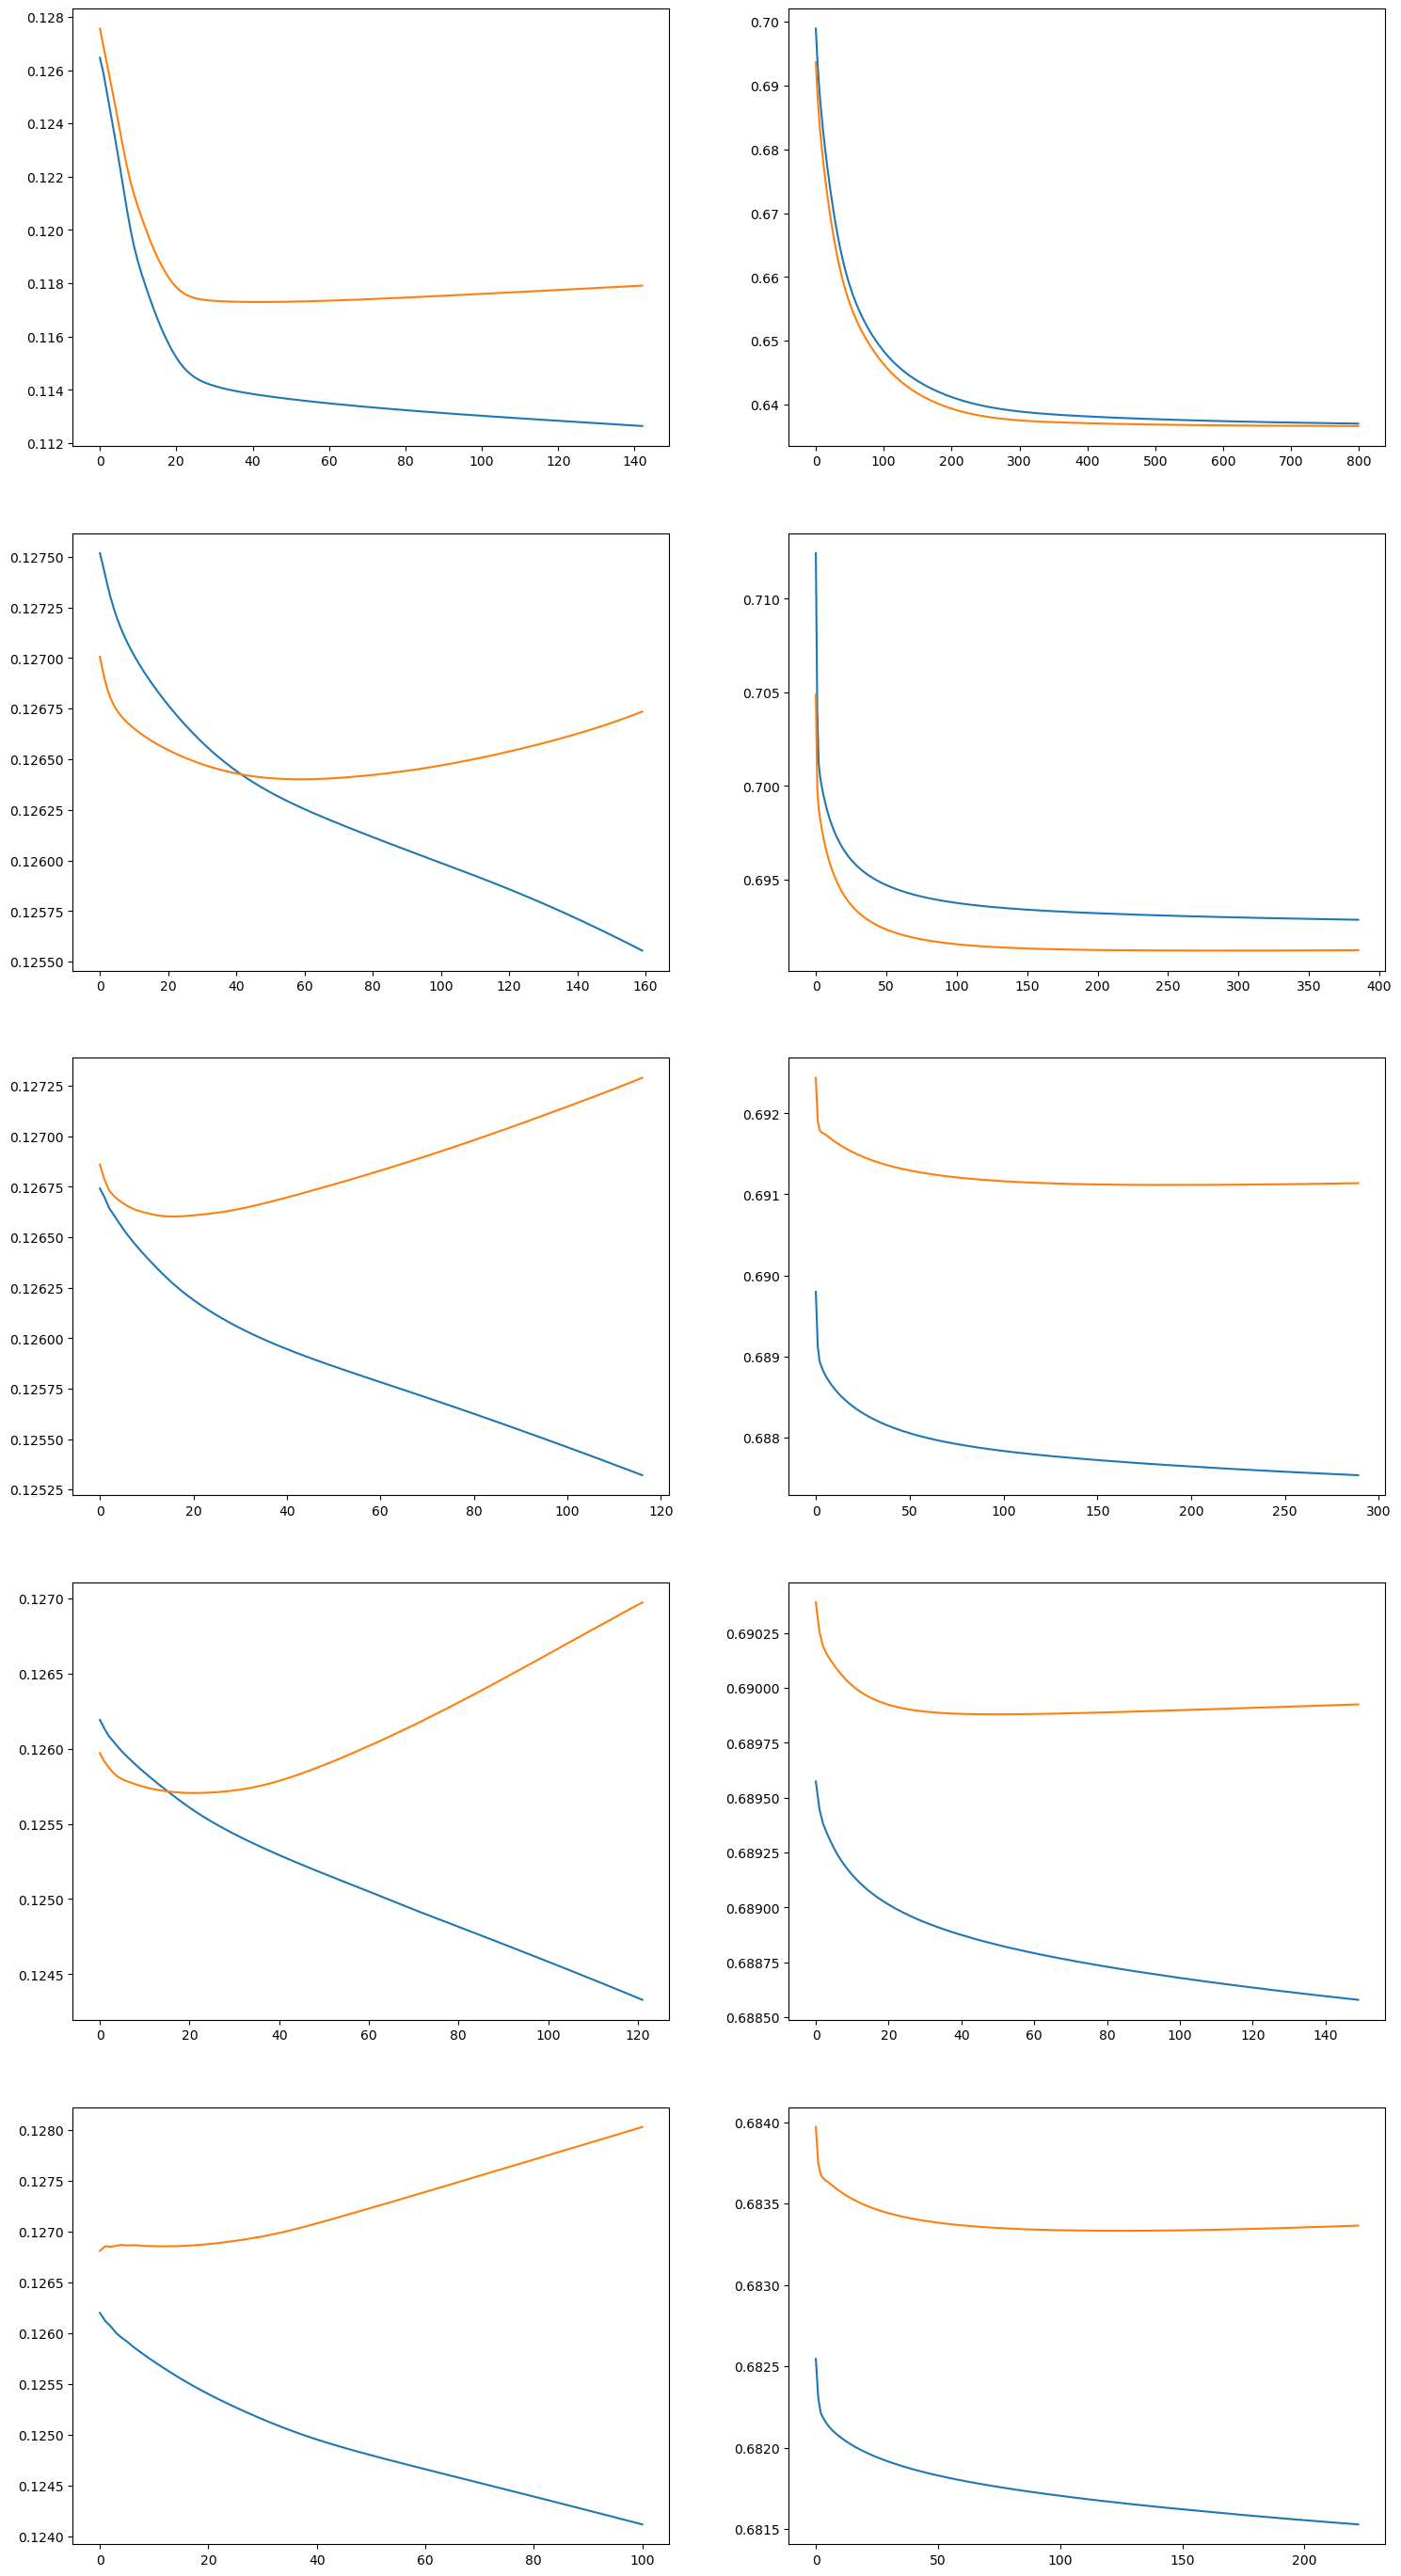

In [28]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

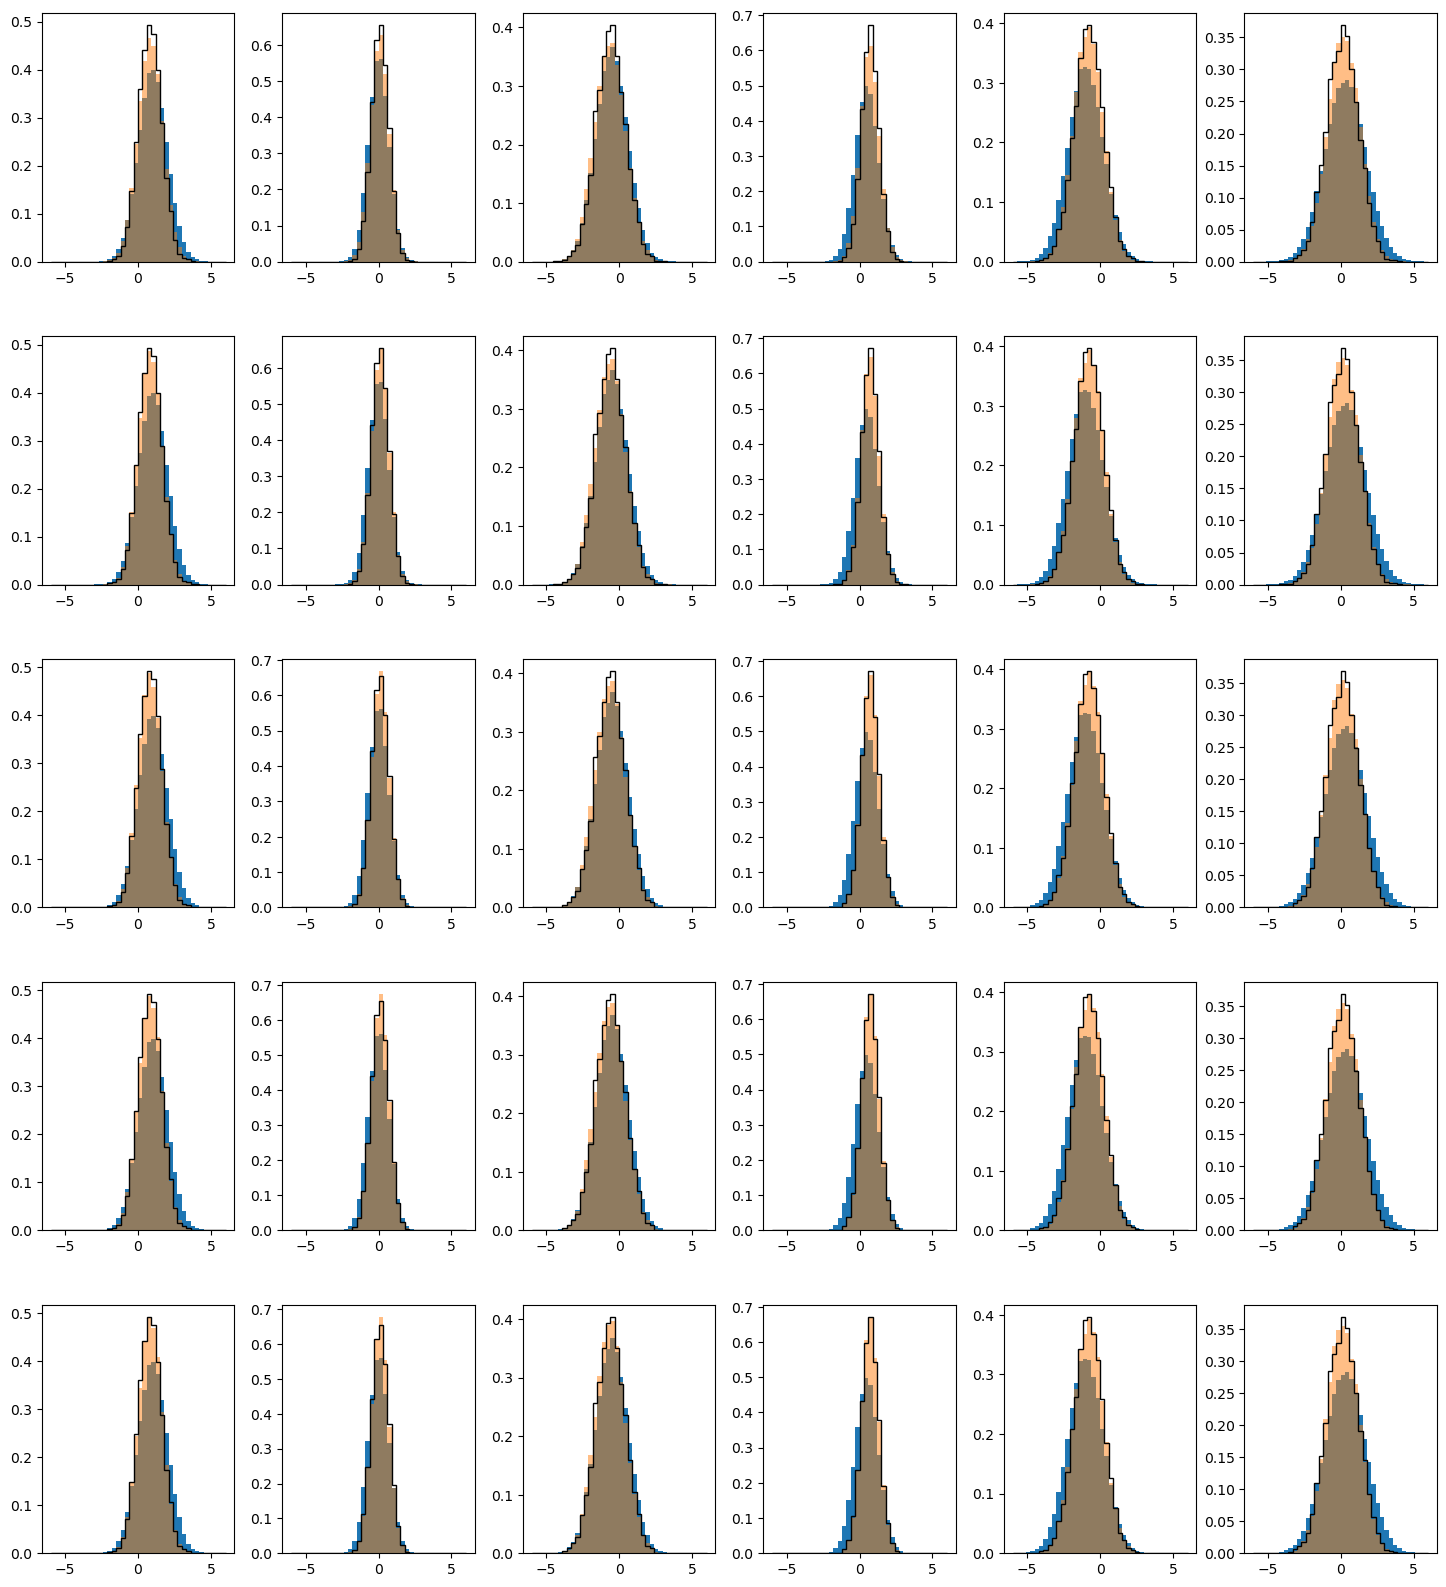

In [29]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]
            
            axi.hist( mc_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         axi.hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]
        
            hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         axi.hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
   
    



plt.show

In [30]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

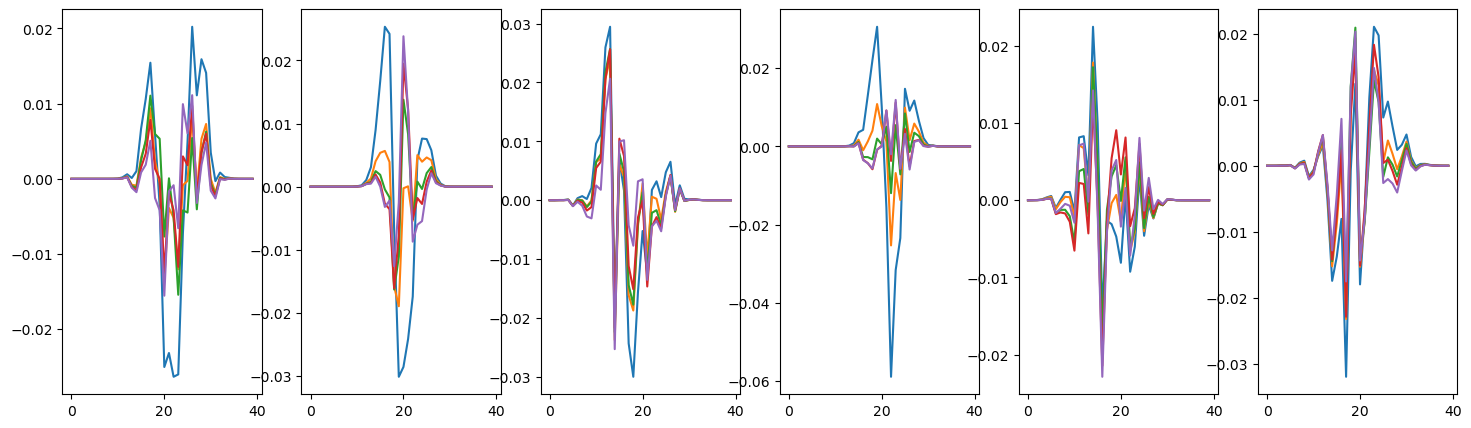

In [31]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

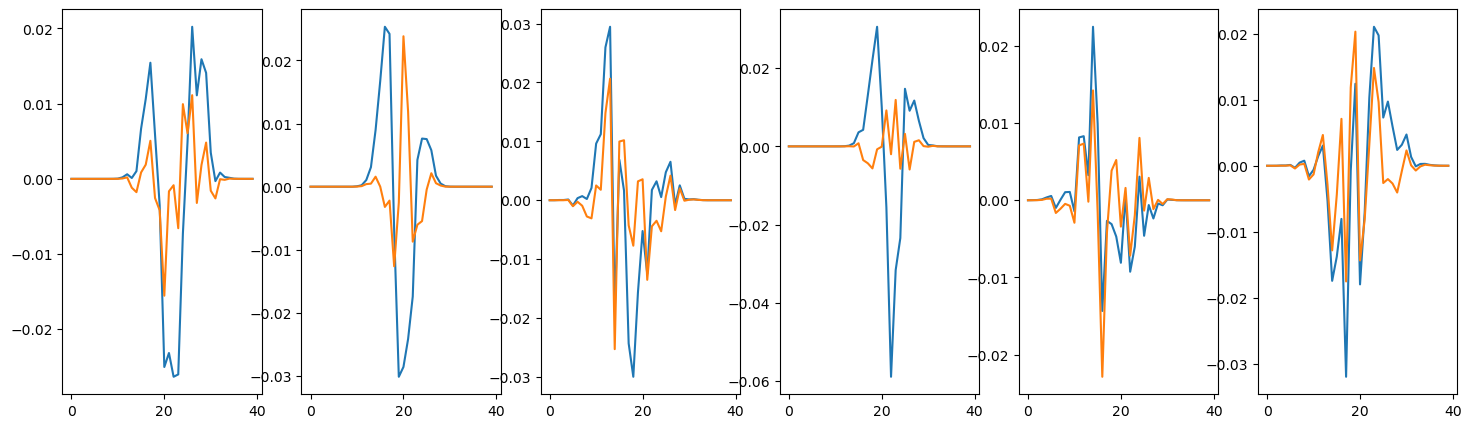

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

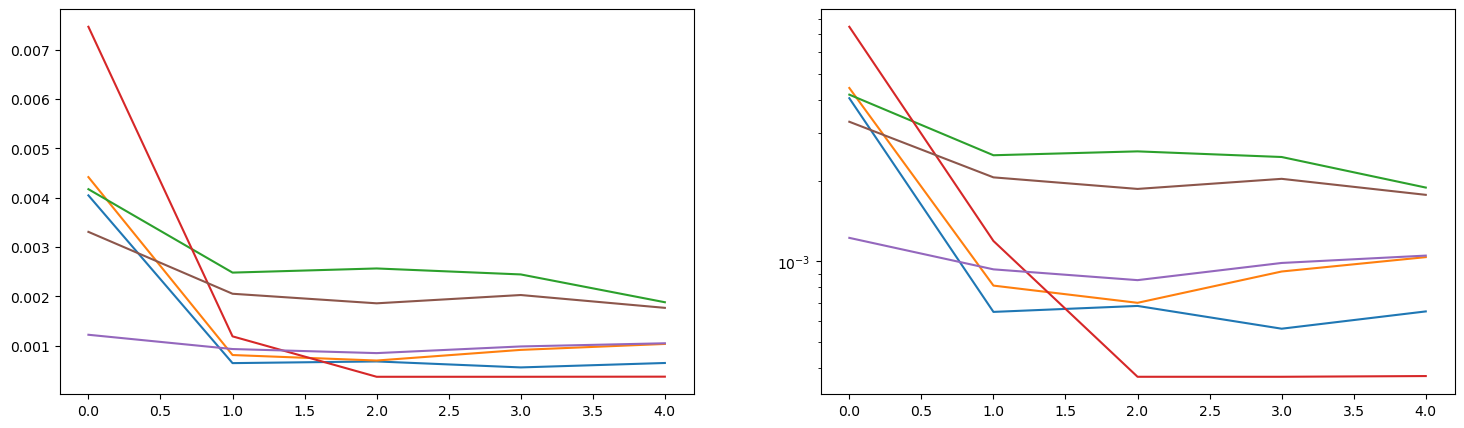

In [33]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

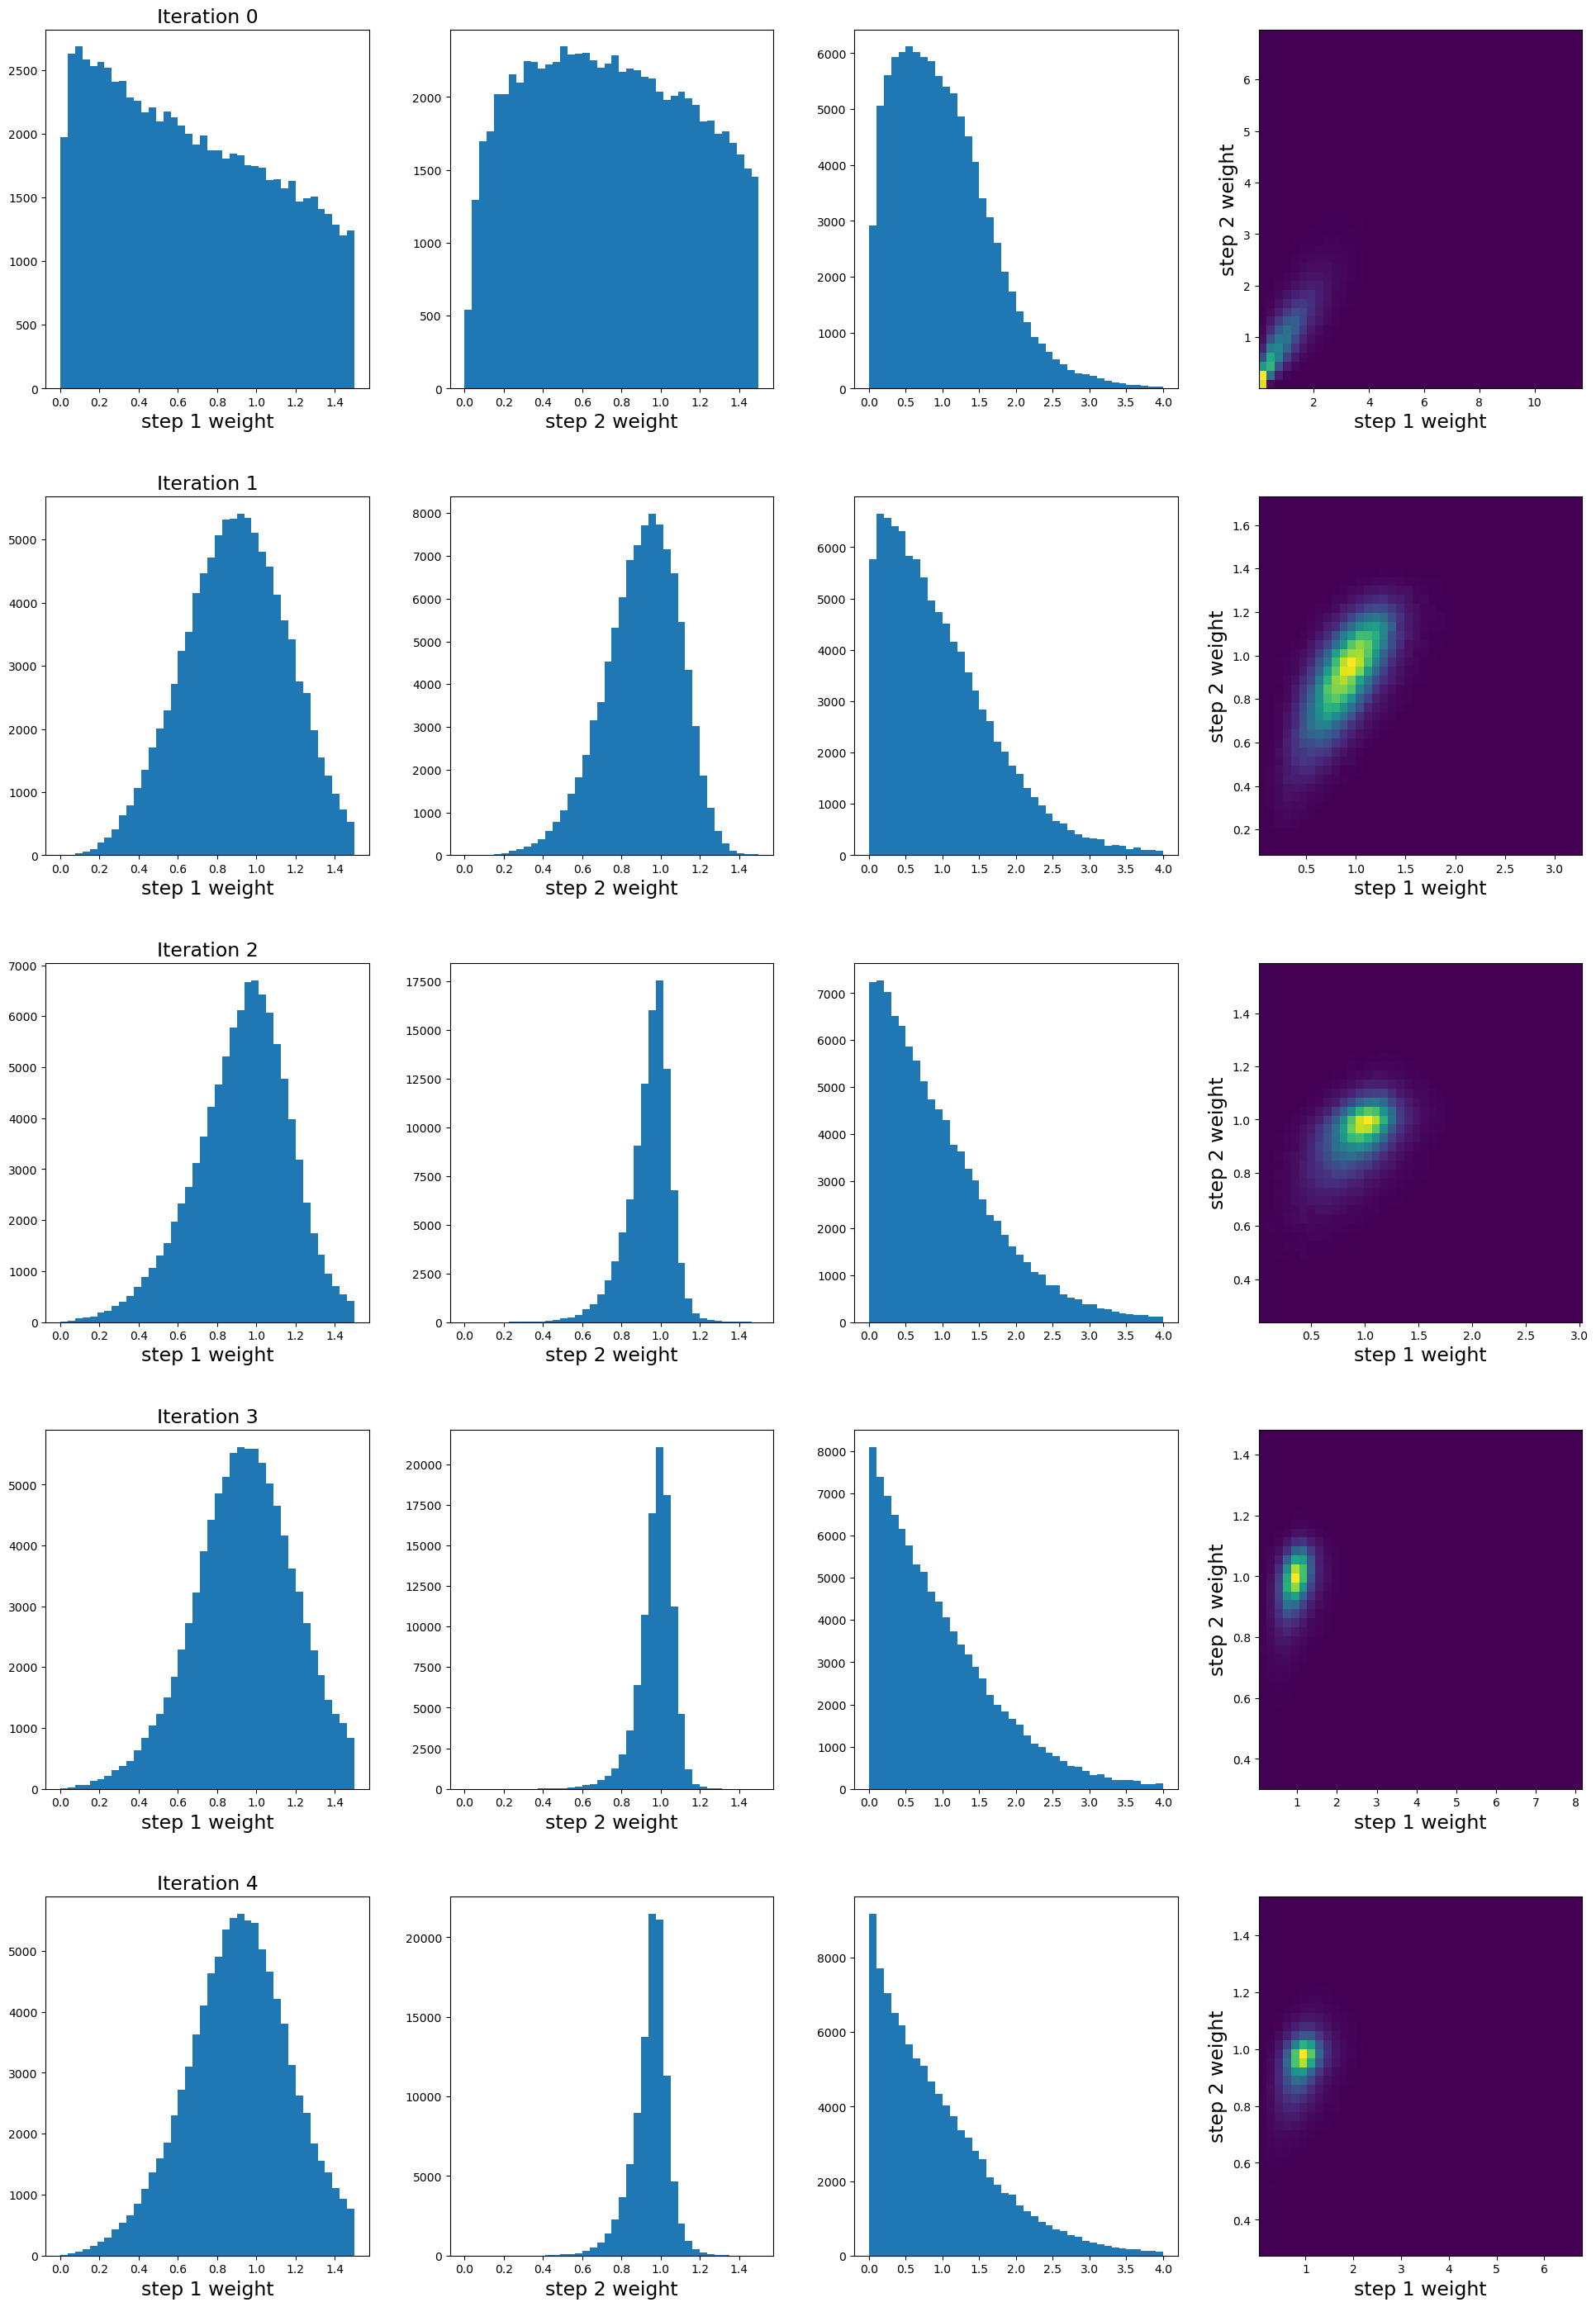

In [34]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,4.] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

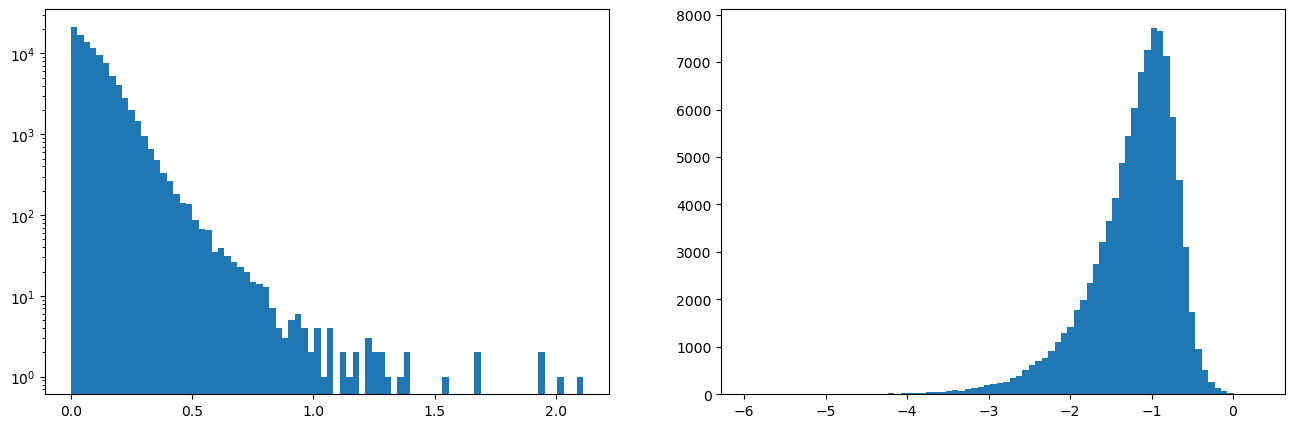

In [35]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

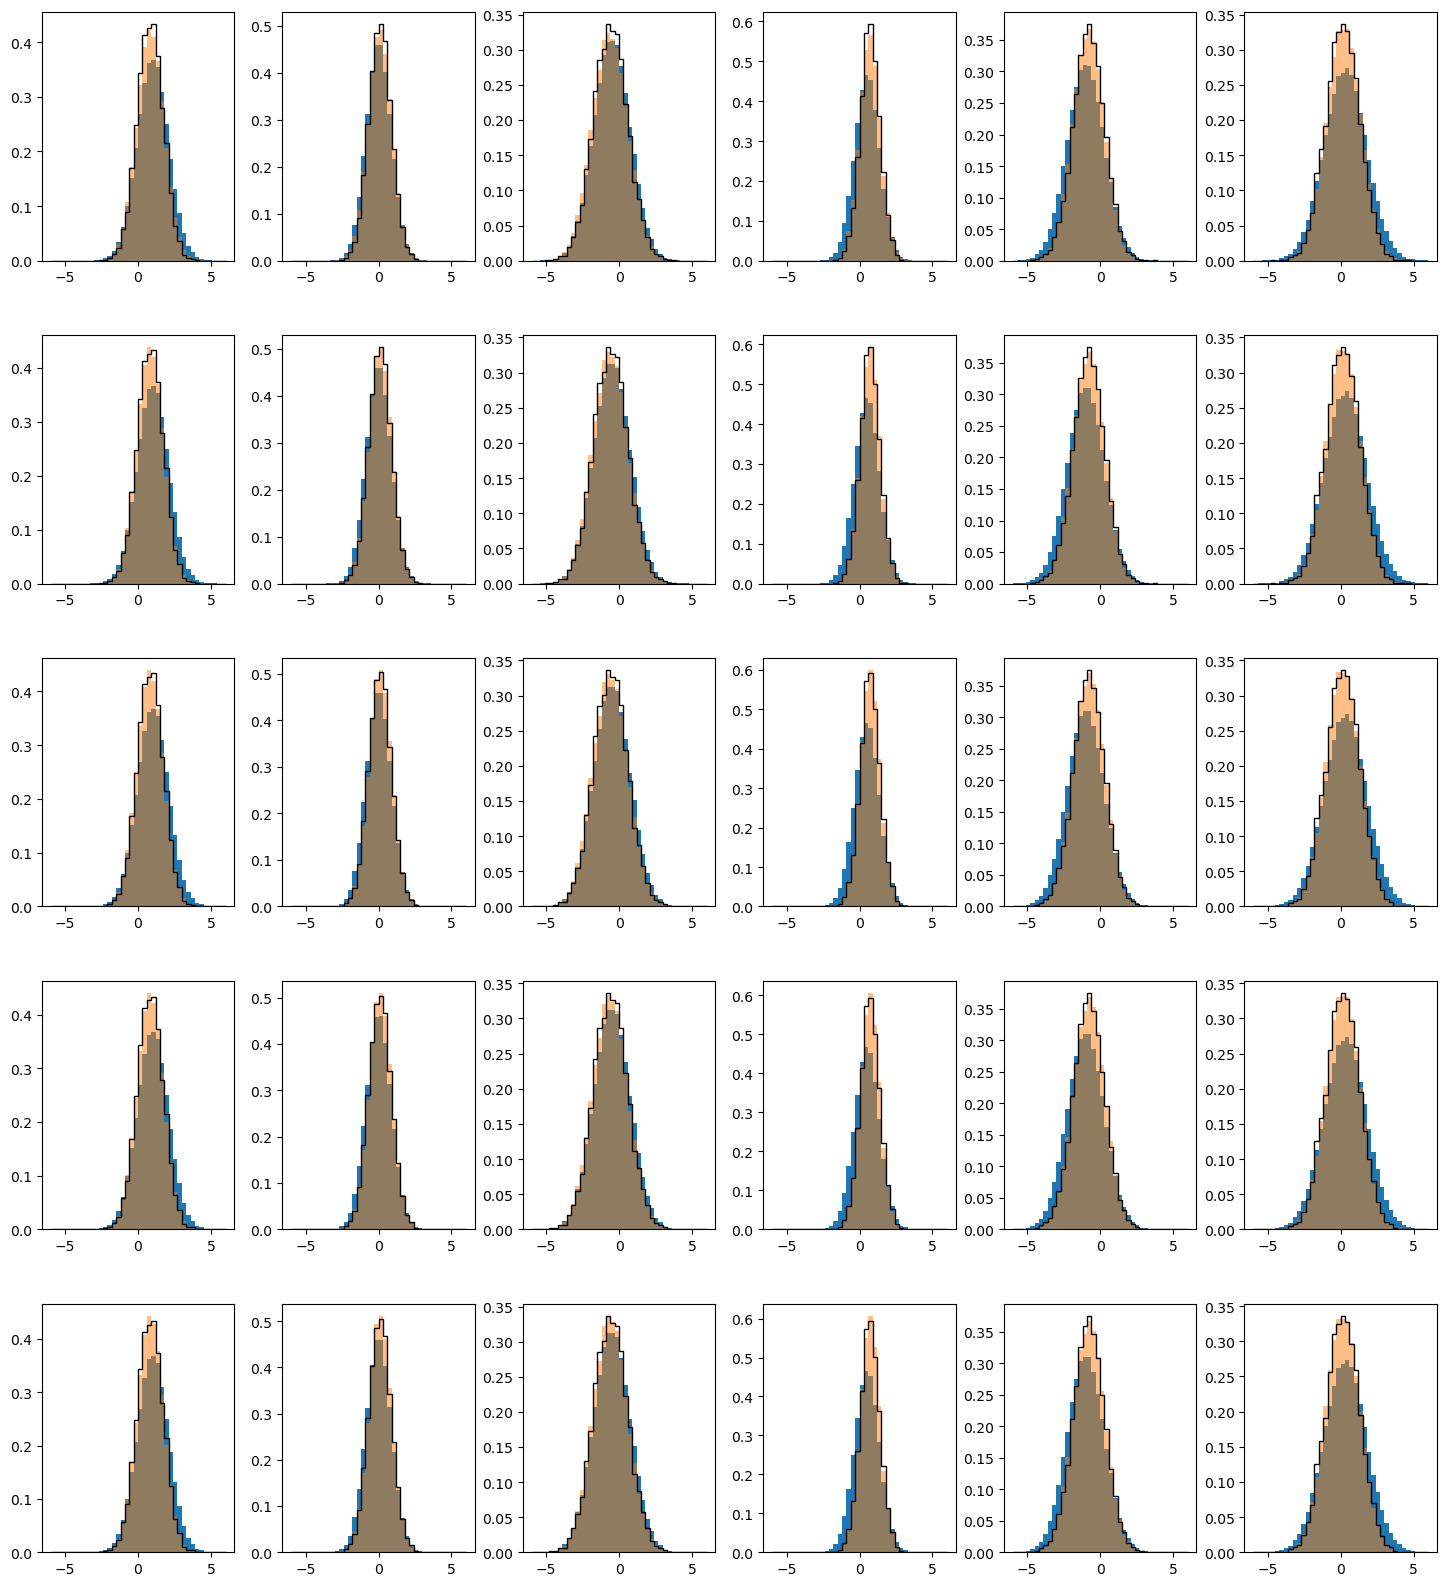

In [36]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]
            
            axi.hist( mc_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         axi.hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :
            
            if ndim == 1 :
                axi = ax[ofi]
            else :
                axi = ax[ofi][di]

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = axi.hist( mc_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         axi.hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    



plt.show

In [37]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

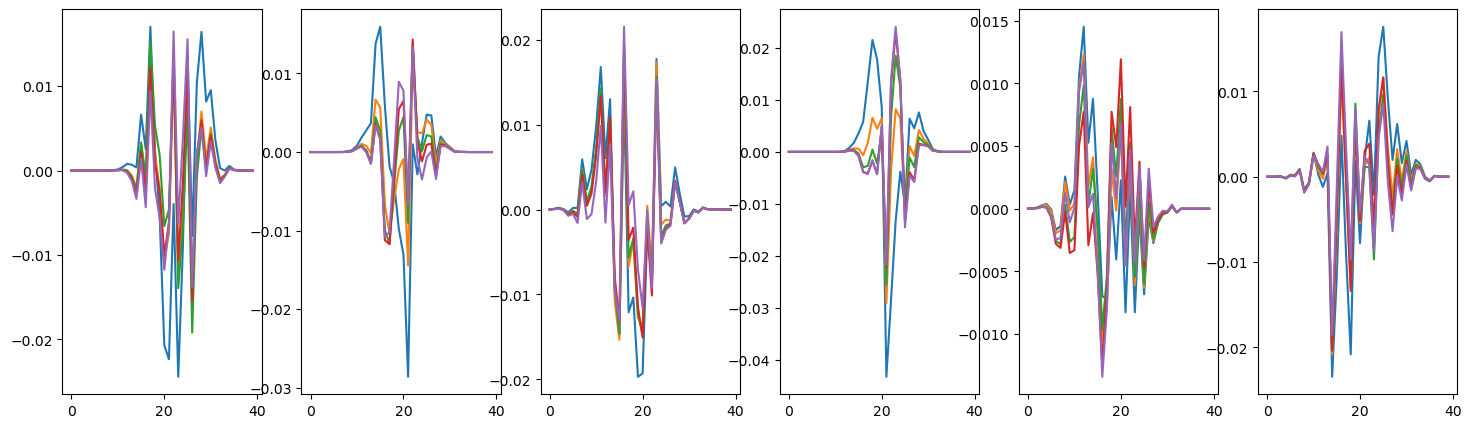

In [38]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

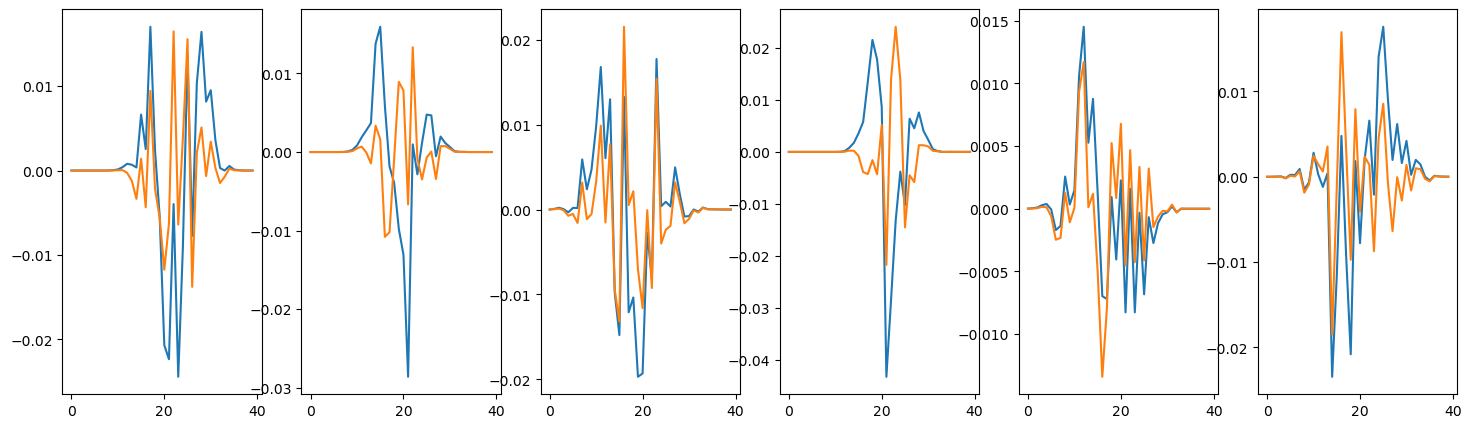

In [39]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

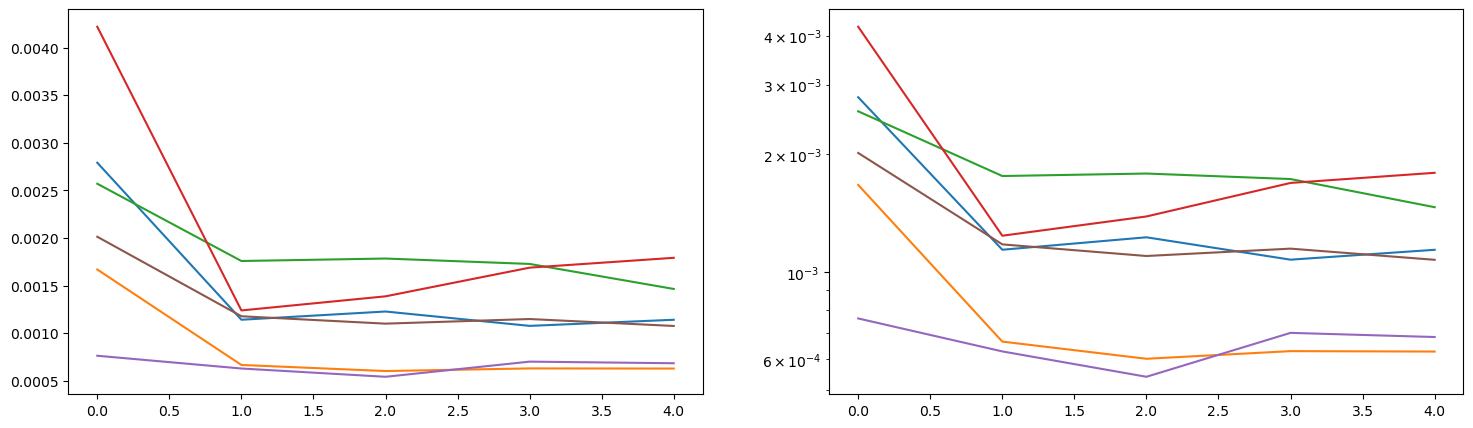

In [40]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [41]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.795      step 2 mean  1.008  rms 0.668
  iter  1 : step 1 mean  0.906  rms 0.278      step 2 mean  0.904  rms 0.191
  iter  2 : step 1 mean  0.940  rms 0.256      step 2 mean  0.940  rms 0.111
  iter  3 : step 1 mean  0.977  rms 0.310      step 2 mean  0.976  rms 0.088
  iter  4 : step 1 mean  0.946  rms 0.316      step 2 mean  0.947  rms 0.092


<function matplotlib.pyplot.show(close=None, block=None)>

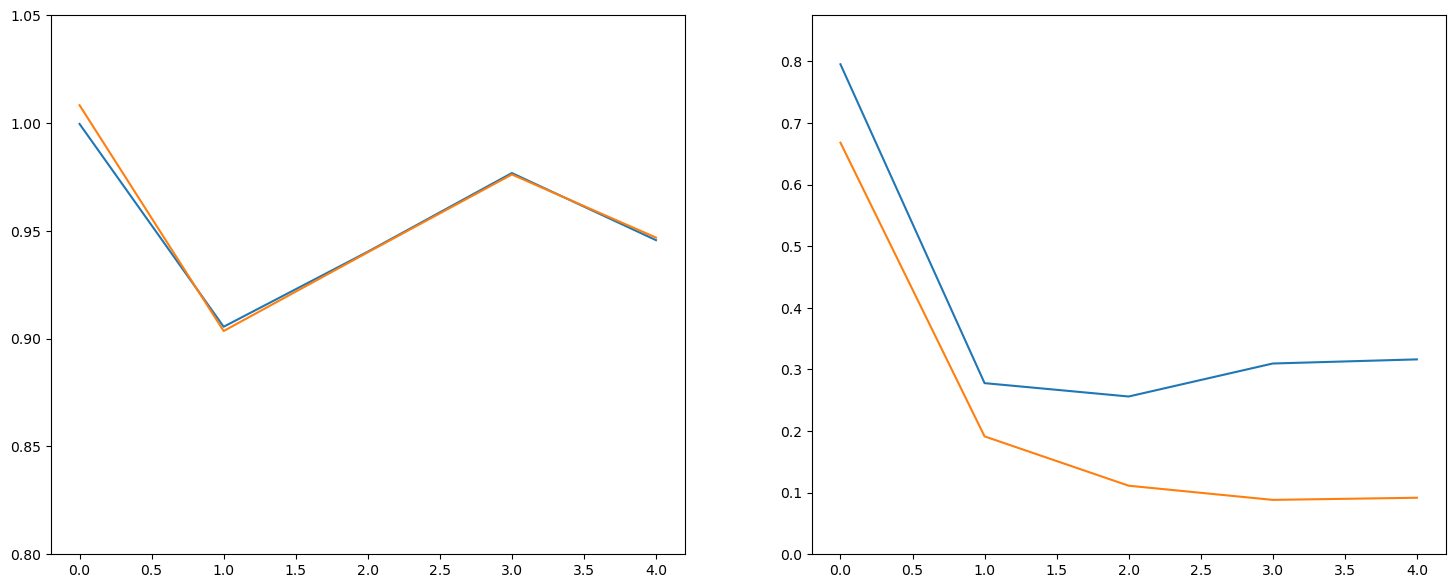

In [42]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

In [43]:

verbose = False



import gc

In [44]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


problem creating bootstrap-nn-models dir


In [ ]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    this_random_seed = random_seed*10000+bi
    
    np.random.seed( this_random_seed )
    keras.utils.set_random_seed( this_random_seed )

    
    if do_bootstrap :
        print("\n\n\n\n ============= Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n\n\n\n ============= Creating toy sample %3d,  this_ngen_true = %d" % (bi, this_ngen_true) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )

        

    #-- Reset the model to ensure fresh random weights for each bootstrap


    model_step1 = Sequential()

    model_step1.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

    if number_of_layers > 1 :
        model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step1.add( BatchNormalization() )
        model_step1.add( Dropout(dropout_setval) )

    if number_of_layers > 2 :
        model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step1.add( BatchNormalization() )
        model_step1.add( Dropout(dropout_setval) )

    model_step1.add( Dense(1, activation='sigmoid') )





    model_step2 = Sequential()

    model_step2.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

    if number_of_layers > 1 :
        model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step2.add( BatchNormalization() )
        model_step2.add( Dropout(dropout_setval) )

    if number_of_layers > 2 :
        model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step2.add( BatchNormalization() )
        model_step2.add( Dropout(dropout_setval) )

    model_step2.add( Dense(1, activation='sigmoid') )



    opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
    opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

    model_step1.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step1,
                          metrics=['accuracy'])

    model_step2.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step2,
                          metrics=['accuracy'])


        
        
    boot_of_return_dict = omnifold( 
        mc_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, True, modeldir, patience_setval, restore_best_weights_setval )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(mc_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    





 ============= Creating toy sample   0,  this_ngen_true = 10013


 *** probelm creating model output directory : output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]


/usr/lib/python3/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 133: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-000/of-step2-iter00-model
 weights_push at the beginning
[0.48484311 0.39962325 1.28108001 ... 1.51573777 0.3014771  0.73911083]
Epoch 139: early stopping
Epoch 349: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-000/of-step2-iter01-model
 weights_push at the beginning
[0.31276035 0.25055269 1.16070028 ... 1.71385878 0.21086021 0.68658221]
Epoch 109: early stopping
Epoch 149: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-000/of-step2-iter02-model
 weights_push at the beginning
[0.25617947 0.20843457 1.08281336 ... 1.81632511 0.19196217 0.81124383]
Epoch 108: early stopping
Epoch 158: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-m

Epoch 141: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-005/of-step2-iter00-model
 weights_push at the beginning
[0.58591813 0.37451467 1.29313064 ... 1.839077   0.40604404 0.77060354]
Epoch 153: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-005/of-step2-iter01-model
 weights_push at the beginning
[0.45749552 0.28071135 1.13904489 ... 1.90035912 0.28818854 0.73782224]
Epoch 106: early stopping
Epoch 281: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-005/of-step2-iter02-model
 weights_push at the beginning
[0.34980938 0.22129937 0.9827587  ... 2.10640355 0.2664351  0.67546437]
Epoch 115: early stopping
Epoch 204: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-005/of-step2-iter

Epoch 137: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-010/of-step2-iter00-model
 weights_push at the beginning
[0.5153935  0.51484567 1.36481678 ... 1.65245259 0.46964261 0.7764951 ]
Epoch 128: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-010/of-step2-iter01-model
 weights_push at the beginning
[0.2850309  0.29033617 1.08253381 ... 2.03953716 0.30851192 0.66129576]
Epoch 122: early stopping
Epoch 214: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-010/of-step2-iter02-model
 weights_push at the beginning
[0.22538258 0.2060386  0.97328086 ... 2.157149   0.2897347  0.63566665]
Epoch 118: early stopping
Epoch 159: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-010/of-step2-iter

Epoch 105: early stopping
Epoch 309: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-015/of-step2-iter02-model
 weights_push at the beginning
[0.30319942 0.23184594 0.96747088 ... 1.51523391 0.30122133 0.5003209 ]
Epoch 115: early stopping
Epoch 313: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-015/of-step2-iter03-model
 weights_push at the beginning
[0.29522005 0.24678012 0.79120113 ... 1.33431331 0.29362666 0.46341894]
Epoch 102: early stopping
Epoch 144: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-015/of-step2-iter04-model


 bootstrap 15 final push weights scaled:
[0.02923487 0.02532606 0.07079135 ... 0.13985135 0.02725387 0.04438367]




 ============= Creating toy sample  16,  this_ngen_true = 9957
 weights_push at the beginning
[1. 1. 1. ... 1. 

Epoch 115: early stopping
Epoch 254: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-020/of-step2-iter04-model


 bootstrap 20 final push weights scaled:
[0.01849622 0.01552825 0.07558    ... 0.16913145 0.05242088 0.03546695]




 ============= Creating toy sample  21,  this_ngen_true = 10092
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 126: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-021/of-step2-iter00-model
 weights_push at the beginning
[0.5241667  0.3349078  1.22363687 ... 1.58941066 0.41795391 0.55065417]
Epoch 150: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-021/of-step2-iter01-model
 weights_push at the beginning
[0.30199209 0.1892265  0.9888547  ... 1.8088439  0.39565406 0.50545457]
Epoch 119: early stopping
Epoch 312: early s

Epoch 130: early stopping
Epoch 357: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-026/of-step2-iter01-model
 weights_push at the beginning
[0.34692557 0.26512229 1.04670308 ... 1.58994499 0.20998129 0.49152167]
Epoch 102: early stopping
Epoch 192: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-026/of-step2-iter02-model
 weights_push at the beginning
[0.31239335 0.2393292  0.8981348  ... 1.63791888 0.16223525 0.43604677]
Epoch 105: early stopping
Epoch 166: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-026/of-step2-iter03-model
 weights_push at the beginning
[0.28734941 0.20848671 0.76339538 ... 1.65320209 0.16509118 0.36508647]
Epoch 116: early stopping
Epoch 239: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-

Epoch 121: early stopping
Epoch 140: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-031/of-step2-iter03-model
 weights_push at the beginning
[0.27112078 0.29644549 1.15478603 ... 1.5668186  0.2376569  0.71178834]
Epoch 104: early stopping
Epoch 217: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-031/of-step2-iter04-model


 bootstrap 31 final push weights scaled:
[0.02475737 0.03066758 0.11505846 ... 0.15247586 0.01964687 0.07611711]




 ============= Creating toy sample  32,  this_ngen_true = 10065
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 156: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-032/of-step2-iter00-model
 weights_push at the beginning
[0.51473624 0.43561441 1.16688144 ... 1.58169639 0.43974051 0.69061118]
Epoch 133: early s





 ============= Creating toy sample  37,  this_ngen_true = 9985
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 160: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-037/of-step2-iter00-model
 weights_push at the beginning
[0.55333328 0.45279443 1.18496716 ... 1.63406456 0.34294498 0.91155475]
Epoch 124: early stopping
Epoch 321: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-037/of-step2-iter01-model
 weights_push at the beginning
[0.35410562 0.28086795 0.95868189 ... 1.88138279 0.21384128 0.88891999]
Epoch 111: early stopping
Epoch 296: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-037/of-step2-iter02-model
 weights_push at the beginning
[0.30296106 0.26271207 0.78709061 ... 1.99948147 0.17071869 0.88241624]
Epoch 101: early stopping
Epoch


 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-042/of-step2-iter01-model
 weights_push at the beginning
[0.30630881 0.35360301 1.10185263 ... 1.45862085 0.30034956 0.72164718]
Epoch 124: early stopping
Epoch 274: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-042/of-step2-iter02-model
 weights_push at the beginning
[0.23145828 0.26258226 0.90185349 ... 1.44564914 0.2967945  0.75928246]
Epoch 122: early stopping
Epoch 202: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-042/of-step2-iter03-model
 weights_push at the beginning
[0.17208236 0.20342153 0.82327122 ... 1.43701681 0.30738634 0.72740102]
Epoch 129: early stopping
Epoch 107: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-042/of-step2-iter

Epoch 113: early stopping
Epoch 223: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-047/of-step2-iter03-model
 weights_push at the beginning
[0.17371907 0.1432658  0.85191942 ... 2.08176094 0.55126156 0.93267435]
Epoch 124: early stopping
Epoch 161: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-047/of-step2-iter04-model


 bootstrap 47 final push weights scaled:
[0.01645932 0.01266361 0.08939732 ... 0.22332223 0.06104156 0.09183514]




 ============= Creating toy sample  48,  this_ngen_true = 9886
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 140: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-048/of-step2-iter00-model
 weights_push at the beginning
[0.49601382 0.45090738 1.2464608  ... 1.68230009 0.45575401 0.61396456]
Epoch 170: early st





 ============= Creating toy sample  53,  this_ngen_true = 9982
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 145: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-053/of-step2-iter00-model
 weights_push at the beginning
[0.48869327 0.38251936 1.40295088 ... 1.57396722 0.51534975 0.56215304]
Epoch 141: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-053/of-step2-iter01-model
 weights_push at the beginning
[0.38125026 0.28019042 1.19217563 ... 1.64165998 0.40076136 0.45590524]
Epoch 104: early stopping
Epoch 129: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-053/of-step2-iter02-model
 weights_push at the beginning
[0.29867352 0.23642877 0.98400684 ... 1.78496623 0.37405555 0.4807075 ]
Epoch 120: early stopping
Epoch 238: early stopping

 +++

Epoch 111: early stopping
Epoch 154: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-058/of-step2-iter02-model
 weights_push at the beginning
[0.33571533 0.23672655 0.89260007 ... 1.65219802 0.50524171 0.3736893 ]
Epoch 111: early stopping
Epoch 219: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-058/of-step2-iter03-model
 weights_push at the beginning
[0.33642165 0.19645837 0.76941779 ... 1.73887146 0.48753029 0.37841372]
Epoch 130: early stopping
Epoch 107: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-058/of-step2-iter04-model


 bootstrap 58 final push weights scaled:
[0.03074378 0.01642378 0.06759004 ... 0.19227131 0.04817373 0.03437504]




 ============= Creating toy sample  59,  this_ngen_true = 10022
 weights_push at the beginning
[1. 1. 1. ... 1.

Epoch 103: early stopping
Epoch 180: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-063/of-step2-iter04-model


 bootstrap 63 final push weights scaled:
[0.03047925 0.03848566 0.07556524 ... 0.23587217 0.03508043 0.05335198]




 ============= Creating toy sample  64,  this_ngen_true = 10011
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 132: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-064/of-step2-iter00-model
 weights_push at the beginning
[0.47369787 0.38874799 1.19397628 ... 1.5669297  0.40566921 0.70609915]
Epoch 129: early stopping
Epoch 323: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-064/of-step2-iter01-model
 weights_push at the beginning
[0.33445934 0.26259733 1.06671622 ... 1.56586797 0.3308696  0.65799029]
Epoch 120: early s

Epoch 160: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-069/of-step2-iter00-model
 weights_push at the beginning
[0.48212397 0.35292721 1.16754496 ... 1.63349807 0.54257518 0.65298074]
Epoch 140: early stopping
Epoch 317: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-069/of-step2-iter01-model
 weights_push at the beginning
[0.37459079 0.2686714  0.94340907 ... 1.87097411 0.47740833 0.62524614]
Epoch 124: early stopping
Epoch 371: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-069/of-step2-iter02-model
 weights_push at the beginning
[0.3371265  0.22898692 0.88684653 ... 2.05887651 0.4454361  0.4906471 ]
Epoch 109: early stopping
Epoch 155: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-m

Epoch 111: early stopping
Epoch 194: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-074/of-step2-iter02-model
 weights_push at the beginning
[0.23190045 0.16259263 1.0879943  ... 2.26508981 0.40739175 0.47850636]
Epoch 103: early stopping
Epoch 299: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-074/of-step2-iter03-model
 weights_push at the beginning
[0.19051215 0.14016127 0.93566046 ... 2.22168076 0.35454947 0.46499727]
Epoch 102: early stopping
Epoch 253: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-074/of-step2-iter04-model


 bootstrap 74 final push weights scaled:
[0.0150419  0.01065444 0.08122443 ... 0.21239282 0.03394956 0.04347331]




 ============= Creating toy sample  75,  this_ngen_true = 10061
 weights_push at the beginning
[1. 1. 1. ... 1.

Epoch 101: early stopping
Epoch 238: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-079/of-step2-iter04-model


 bootstrap 79 final push weights scaled:
[0.02190989 0.01998713 0.05796568 ... 0.13955016 0.01283    0.05034505]




 ============= Creating toy sample  80,  this_ngen_true = 9953
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 145: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-080/of-step2-iter00-model
 weights_push at the beginning
[0.43821034 0.33727983 1.20221245 ... 1.58290422 0.47906664 0.59283763]
Epoch 122: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-080/of-step2-iter01-model
 weights_push at the beginning
[0.29158431 0.23248654 0.99401138 ... 1.75262952 0.40659025 0.54036619]
Epoch 113: early stopping

 +++ Saving step 2

Epoch 145: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-085/of-step2-iter01-model
 weights_push at the beginning
[0.37049717 0.19088879 1.09753841 ... 1.69645276 0.32137378 1.06420074]
Epoch 121: early stopping
Epoch 375: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-085/of-step2-iter02-model
 weights_push at the beginning
[0.2790162  0.13330386 0.91339553 ... 1.76923012 0.29992317 1.02854042]
Epoch 124: early stopping
Epoch 163: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-085/of-step2-iter03-model
 weights_push at the beginning
[0.2271067  0.11828446 0.8265588  ... 1.68318139 0.27116075 1.1029773 ]
Epoch 101: early stopping
Epoch 287: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-m

Epoch 134: early stopping
Epoch 167: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-090/of-step2-iter03-model
 weights_push at the beginning
[0.26324999 0.13605117 0.71612601 ... 1.53487916 0.18399794 0.30707956]
Epoch 120: early stopping
Epoch 123: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-090/of-step2-iter04-model


 bootstrap 90 final push weights scaled:
[0.02505082 0.01232418 0.06833805 ... 0.17019689 0.01438515 0.03014904]




 ============= Creating toy sample  91,  this_ngen_true = 9955
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 139: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-091/of-step2-iter00-model
 weights_push at the beginning
[0.44597429 0.39509955 1.22383702 ... 1.47919941 0.45888707 0.64886177]
Epoch 143: early st





 ============= Creating toy sample  96,  this_ngen_true = 9927
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 153: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-096/of-step2-iter00-model
 weights_push at the beginning
[0.38420215 0.30528185 1.30074298 ... 1.52903581 0.40796062 0.67091757]
Epoch 148: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-096/of-step2-iter01-model
 weights_push at the beginning
[0.25566083 0.17742273 1.07549483 ... 1.68328735 0.38341971 0.58674515]
Epoch 142: early stopping
Epoch 215: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-096/of-step2-iter02-model
 weights_push at the beginning
[0.19561296 0.14025502 0.92088475 ... 1.82275048 0.37766874 0.5568727 ]
Epoch 128: early stopping

 +++ Saving step 2, iteration 

Epoch 121: early stopping
Epoch 215: early stopping

 +++ Saving step 2, iteration 2 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-101/of-step2-iter02-model
 weights_push at the beginning
[0.23458096 0.1646678  1.01281032 ... 1.77777386 0.34987025 0.58677652]
Epoch 101: early stopping
Epoch 156: early stopping

 +++ Saving step 2, iteration 3 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-101/of-step2-iter03-model
 weights_push at the beginning
[0.21417944 0.14562003 0.88865473 ... 1.86115427 0.42998873 0.53602829]
Epoch 106: early stopping
Epoch 161: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-101/of-step2-iter04-model


 bootstrap 101 final push weights scaled:
[0.02050881 0.01261365 0.08281703 ... 0.19755704 0.04427498 0.0485764 ]




 ============= Creating toy sample 102,  this_ngen_true = 10065
 weights_push at the beginning
[1. 1. 1. ... 1

Epoch 112: early stopping
Epoch 101: early stopping

 +++ Saving step 2, iteration 4 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-106/of-step2-iter04-model


 bootstrap 106 final push weights scaled:
[0.01121169 0.01182497 0.06956385 ... 0.20806037 0.02891885 0.09468799]




 ============= Creating toy sample 107,  this_ngen_true = 10178
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Epoch 145: early stopping
Epoch 769: early stopping

 +++ Saving step 2, iteration 0 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-107/of-step2-iter00-model
 weights_push at the beginning
[0.57774252 0.45211229 1.25010061 ... 1.42339277 0.43827671 0.47782481]
Epoch 138: early stopping
Epoch 379: early stopping

 +++ Saving step 2, iteration 1 model in output-run-nn-study-nd-v0j-ndim6-res-sf-1.00/bootstrap-nn-models/bs-107/of-step2-iter01-model
 weights_push at the beginning
[0.48377842 0.37590083 1.05199072 ... 1.51682084 0.37544739 0.3

In [ ]:
print('\n\n Done.\n\n')